In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import Lasso
import lightgbm as lgb
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import Lasso
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt


# 1. Loading Dataset

- The dataset is under file 'beer2_ds.csv"
It contains information about different types beer. Each row represents a beer sample and each column represents a feature. 

In [2]:
!ls

'Final copy 3-Copy1.ipynb'  'README - Copy.md'	        beer2_ds.csv
'New folder'		     README.md		        draft.ipynb
 Presentation		     UTA-DataScience-Logo.png  'other work'
'Previous Work'		    'WON copy.ipynb'


In [3]:
beer = pd.read_csv("beer2_ds.csv")

In [4]:
beer

,Sample,Class,QC,0,1,2,3,4,5,6,...,2676,2677,2678,2679,2680,2681,2682,2683,2684,2685
0,5102023_All_QC_003,All,1,1206145,1274830,2207415,4359182,177840,269556,1036610,...,47968,91172,137430,81283,58446,1579045,33833,70105,12436,53816
1,5102023_All_QC_040,All,1,892381,945133,1688109,3208560,135325,478907,539238,...,35206,57453,4010,60423,63424,1472180,62940,76586,11361,44397
2,5102023_BLD_1_022,Blonde,0,967402,1039500,3407085,1738776,449647,727863,923668,...,39964,11866,8123,96319,61191,8758,54,90265,18840,372
3,5102023_BLD_2_023,Blonde,0,984546,1056546,3539493,1735118,225435,150396,4340521,...,13800,6044,5769,8975,5635,2848,262,78235,15432,231
4,5102023_BLD_QC_021,Blonde,1,986604,1059673,1855423,3381080,146978,148355,610422,...,38476,22734,7539,39845,27754,5043,62,78880,9340,254
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,592023_STU_2_008,Stout,0,926734,991006,1746892,3100788,1033615,1424326,1402140,...,17666,10654,221774,137235,101334,2832827,44758,14757,857,80338
67,592023_STU_QC_006,Stout,1,964519,1022076,1842175,3425686,654969,1449777,1478993,...,7289,26478,354104,114836,85896,1770868,22828,20829,1139,71852
68,592023_WHE_1_027,Wheat,0,823458,872604,1530622,2835754,342958,433742,1331621,...,133123,41372,3170,36145,41646,7085,67,49520,2875,106
69,592023_WHE_2_028,Wheat,0,817188,858183,1485663,2986838,168233,254985,1263554,...,3149,15489,8732,47852,25502,4663319,155583,50530,4166,126671


In [5]:
beer.isnull().sum()

Sample    0
Class     0
QC        0
0         0
1         0
         ..
2681      0
2682      0
2683      0
2684      0
2685      0
Length: 2689, dtype: int64

In [6]:
beer.columns

Index(['Sample', 'Class', 'QC', '0', '1', '2', '3', '4', '5', '6',
       ...
       '2676', '2677', '2678', '2679', '2680', '2681', '2682', '2683', '2684',
       '2685'],
      dtype='object', length=2689)

# 2. Data Exploration and Normalization

- Observing min and max feature values for each sample to understand the range of values in the data, the higher the feature value the more prevalent the feature is in this sample. 

In [7]:
#feature values (excluding the label and sample names)
feature_values = beer.iloc[:, 1:].values

# maximum value for each feature
max_feature_values = np.max(feature_values, axis=0)

# minimum value for each feature
min_feature_values = np.min(feature_values, axis=0)

result_df = pd.DataFrame({
    'Feature Index': range(1, len(max_feature_values) + 1),
    'Min Feature Value': min_feature_values,
    'Max Feature Value': max_feature_values})
print(result_df)

      Feature Index Min Feature Value Max Feature Value
0                 1               All             Wheat
1                 2                 0                 1
2                 3            479734           1315544
3                 4            507948           1759020
4                 5            466169           4088947
...             ...               ...               ...
2683           2684                 0           6472603
2684           2685                 0            241154
2685           2686                 0            407731
2686           2687                 0            444990
2687           2688                 0            246497

[2688 rows x 3 columns]


In [8]:
beer.index

RangeIndex(start=0, stop=71, step=1)

# 3. Standardizing the Data (Z-Score Normalization)

- Adjusting all the values so they have a similar range. This is to make comparisons easier and improving the analysis. 

### Z-score Normalization
- The average of each column is subtracted from every value
- The result is divided by the column's standard deviation
- All the columns have values centered around 0

In [9]:
#extracting only the feature columns (excluding the quality control column)
numeric_columns = beer.select_dtypes(include=['int64']).columns[1:]
X_features = beer[numeric_columns]
#apply z-score normalization
X_normalized = (X_features - X_features.mean()) / X_features.std()
#replacing original feature values with normalized values
beer[numeric_columns] = X_normalized

In [10]:
beer

,Sample,Class,QC,0,1,2,3,4,5,6,...,2676,2677,2678,2679,2680,2681,2682,2683,2684,2685
0,5102023_All_QC_003,All,1,1.809258,1.194079,0.459027,1.725280,-0.662678,-0.757899,-0.122617,...,0.625009,1.232157,1.053329,0.591885,0.493292,0.359014,-0.023946,0.423856,-0.018859,0.254570
1,5102023_All_QC_040,All,1,0.094267,-0.062359,-0.191927,0.757690,-0.737201,-0.432879,-0.595712,...,0.279311,0.462032,-0.365107,0.033474,0.639567,0.293633,0.449159,0.550038,-0.038908,0.099415
2,5102023_BLD_1_022,Blonde,0,0.504321,0.297263,1.962822,-0.478292,-0.186236,-0.046372,-0.230046,...,0.408196,-0.579153,-0.321381,0.994390,0.573952,-0.601711,-0.572990,0.816360,0.100581,-0.625789
3,5102023_BLD_2_023,Blonde,0,0.598028,0.362223,2.128796,-0.481368,-0.579250,-0.942896,3.020027,...,-0.300538,-0.712125,-0.346407,-1.343762,-1.058524,-0.605327,-0.569609,0.582143,0.037019,-0.628112
4,5102023_BLD_QC_021,Blonde,1,0.609277,0.374140,0.017802,0.902767,-0.716775,-0.946064,-0.528002,...,0.367889,-0.330933,-0.327589,-0.517389,-0.408572,-0.603984,-0.572860,0.594701,-0.076601,-0.627733
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,592023_STU_2_008,Stout,0,0.282036,0.112458,-0.118242,0.667061,0.837384,1.034895,0.225071,...,-0.195815,-0.606835,1.950021,2.089690,1.753527,1.126097,0.153629,-0.653737,-0.234815,0.691456
67,592023_STU_QC_006,Stout,1,0.488563,0.230862,0.001196,0.940277,0.173667,1.074408,0.298173,...,-0.476908,-0.245422,3.356869,1.490081,1.299892,0.476375,-0.202821,-0.535519,-0.229556,0.551670
68,592023_WHE_1_027,Wheat,0,-0.282456,-0.338759,-0.389338,0.444187,-0.373248,-0.502998,0.157994,...,2.931697,0.094750,-0.374038,-0.616436,-0.000365,-0.602734,-0.572779,0.023078,-0.197178,-0.630171
69,592023_WHE_2_028,Wheat,0,-0.316727,-0.393716,-0.445694,0.571238,-0.679518,-0.780520,0.093250,...,-0.589053,-0.496406,-0.314906,-0.303046,-0.474745,2.246020,1.954979,0.042743,-0.173100,1.454679


# 4. Cleaning the Data

### Removing
- 'Sample' column
- any missing values
- 'Quality Control' (QC) Samples, they are not needed for beer classification
- 'All' and 'Water' are not useful for distinguishing between beer types

### Converting Labels to Numbers 
- The column 'Class' tells which type of beer each row represents. It is better to work with numbers than words, each of the beer types were converted into number labels using label encoding

In [11]:
# Removing 'Sample' column, it is not needed for this analysis
data_cleaned = beer.drop(['Sample'], axis=1)
missing_values = data_cleaned.isnull().sum().sum()
unique_classes = data_cleaned['Class'].unique()
qc_distribution = data_cleaned['QC'].value_counts(normalize=True)
missing_values, unique_classes, qc_distribution

(0,
 array(['All', 'Blonde', 'German', 'IPA', 'Sour', 'Stout', 'Wheat'],
       dtype=object),
 0    0.676056
 1    0.323944
 Name: QC, dtype: float64)

In [12]:
# Exclude QC samples
data_no_qc = data_cleaned[data_cleaned['QC'] == 0].drop('QC', axis=1)

# exclude 'All' and 'Water' classes
data_final = data_no_qc[~data_no_qc['Class'].isin(['All', 'Water'])]

# Encode the 'Class' column using label encoding
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
data_final['Class'] = le.fit_transform(data_final['Class'])

# Prepare features (X) and target (y) for model training
X = data_final.drop('Class', axis=1)
y = data_final['Class']



# 5. Scaling for Machine Learning

- Standard Scaling is used to make sure all the numbers follow a similar pattern, easier for machine learning models to understand

In [13]:
# Feature scaling using StandardScaler
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Display the first few rows of the scaled features and the encoded classes
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
X_scaled_df['Class'] = y.reset_index(drop=True)  # Reset index for proper alignment

X_scaled_df.head(), le.classes_

(          0         1         2         3         4         5         6  \
 0  0.464375  0.371579  1.993775 -0.453424 -0.194811  0.009035 -0.260646   
 1  0.558462  0.441077  2.152566 -0.456548 -0.907172 -0.996273  2.494653   
 2  0.421442  0.297813  0.072168  1.016695 -1.173317 -1.009562 -0.662752   
 3  0.423242  0.295224  0.055786  0.716370 -0.929587 -0.220180 -0.777497   
 4  0.271388  0.196889  0.030773  1.024401 -0.270755 -0.528471 -0.349617   
 
           7         8         9  ...      2677      2678      2679      2680  \
 0 -0.569478 -0.796027 -0.091483  ... -0.443769 -0.267325  0.956375  0.609127   
 1 -0.597264 -0.811228  1.657820  ... -0.574190 -0.294391 -1.276755 -0.981558   
 2 -0.618983 -0.829505 -0.255488  ... -0.275288 -0.251365 -0.394487 -0.387098   
 3 -0.628998 -0.525684 -0.804922  ... -0.335817 -0.330357 -0.083642 -0.648280   
 4 -0.157984  1.302451 -0.551813  ... -0.385167 -0.323918 -0.418290 -0.255734   
 
        2681      2682      2683      2684      2685  

# 6. Identifying Important Features

- Training multiple machine learning models to find the most important features that help distinguish the different beer types. Each model ranked the measurements by how much they contributed to telling the beer types apart.

### Feature Importance

In [14]:
# Printing top 20 features for each model
def display_top_features_table(model_name, top_features, top_importances):
    plt.figure(figsize=(10, 8))
    plt.title(f'Top 20 Features ({model_name})')
    plt.bar(range(len(top_features)), top_importances, color='r', align='center')
    plt.xticks(range(len(top_features)), top_features, rotation=90)
    plt.xlim([-1, len(top_features)])
    plt.ylabel('Importance')
    plt.xlabel('Feature')
    plt.tight_layout()
    plt.show()
    
    # Display the top features in a DataFrame
    top_features_importances = pd.DataFrame({'Feature': top_features, 'Importance': top_importances})
    print(top_features_importances)


# 7. Visualizing the Data

- Using t-SNE (a technique that helps cluster similar things together) and PCA (Principle Component Analysis a method to reduce many columns into just two without loosing too much information) to help visualize how well the features can separate different beer types

In [15]:
def plot_pca_tsne(X_scaled, y, top_features_indices, model_name):
    # Selecting only the top 20 features for t-SNE visualization
    X_top_features = X_scaled[:, top_features_indices]
    
    # Initialize and fit the t-SNE model
    tsne = TSNE(n_components=2, random_state=42)
    X_tsne = tsne.fit_transform(X_top_features)
    
    # Initialize and fit the PCA model
    pca = PCA(n_components=2, random_state=42)
    X_pca = pca.fit_transform(X_top_features)
    
    # Plotting side by side
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    # Calculate the total variance explained by the principal components
    total_variance_explained = np.sum(pca.explained_variance_ratio_)
    
    # Plot t-SNE visualization
    axes[0].set_title(f't-SNE Visualization of Beer Classes ({model_name})', fontsize=16, fontweight='bold')
    for class_id in np.unique(y):
        axes[0].scatter(X_tsne[y == class_id, 0], X_tsne[y == class_id, 1], label=le.inverse_transform([class_id])[0])
    axes[0].set_xlabel('t-SNE 1', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('t-SNE 2', fontsize=14, fontweight='bold')
    axes[0].legend()
    
    # Plot PCA visualization
    axes[1].set_title(f'PCA Visualization of Beer Classes ({model_name})', fontsize=16, fontweight='bold')
    for class_id in np.unique(y):
        axes[1].scatter(X_pca[y == class_id, 0], X_pca[y == class_id, 1], label=le.inverse_transform([class_id])[0])
    axes[1].set_xlabel('Principal Component 1', fontsize=14, fontweight='bold')
    axes[1].set_ylabel('Principal Component 2', fontsize=14, fontweight='bold')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()


# 8. Training Different Machine Learning Models

- Using different models to see how well they could predict beer types based on the given measurements. Each model analyzed the data and learned patterns.

1. Random Forest (uses many decision trees to make predictions)
2. XGBoost (a powerful boosting technique that improves decision trees)
3. LASSO Regression (helps pick out the most relevant features)
4. LightGBM (a faster boosting method for handling big datasets)
5. Gradient Boosting Classifier (another boosting method that builds models in stages)


## Random Forest

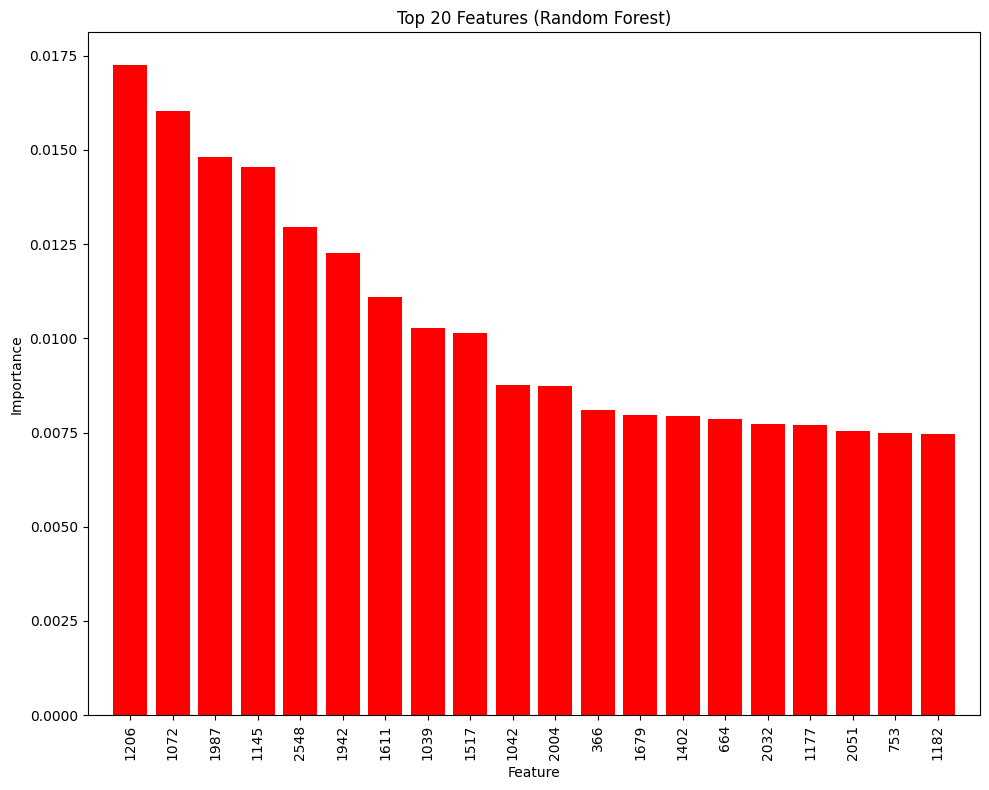

   Feature  Importance
0     1206    0.017253
1     1072    0.016042
2     1987    0.014805
3     1145    0.014537
4     2548    0.012954
5     1942    0.012255
6     1611    0.011090
7     1039    0.010280
8     1517    0.010150
9     1042    0.008764
10    2004    0.008736
11     366    0.008098
12    1679    0.007954
13    1402    0.007941
14     664    0.007851
15    2032    0.007728
16    1177    0.007690
17    2051    0.007540
18     753    0.007485
19    1182    0.007461


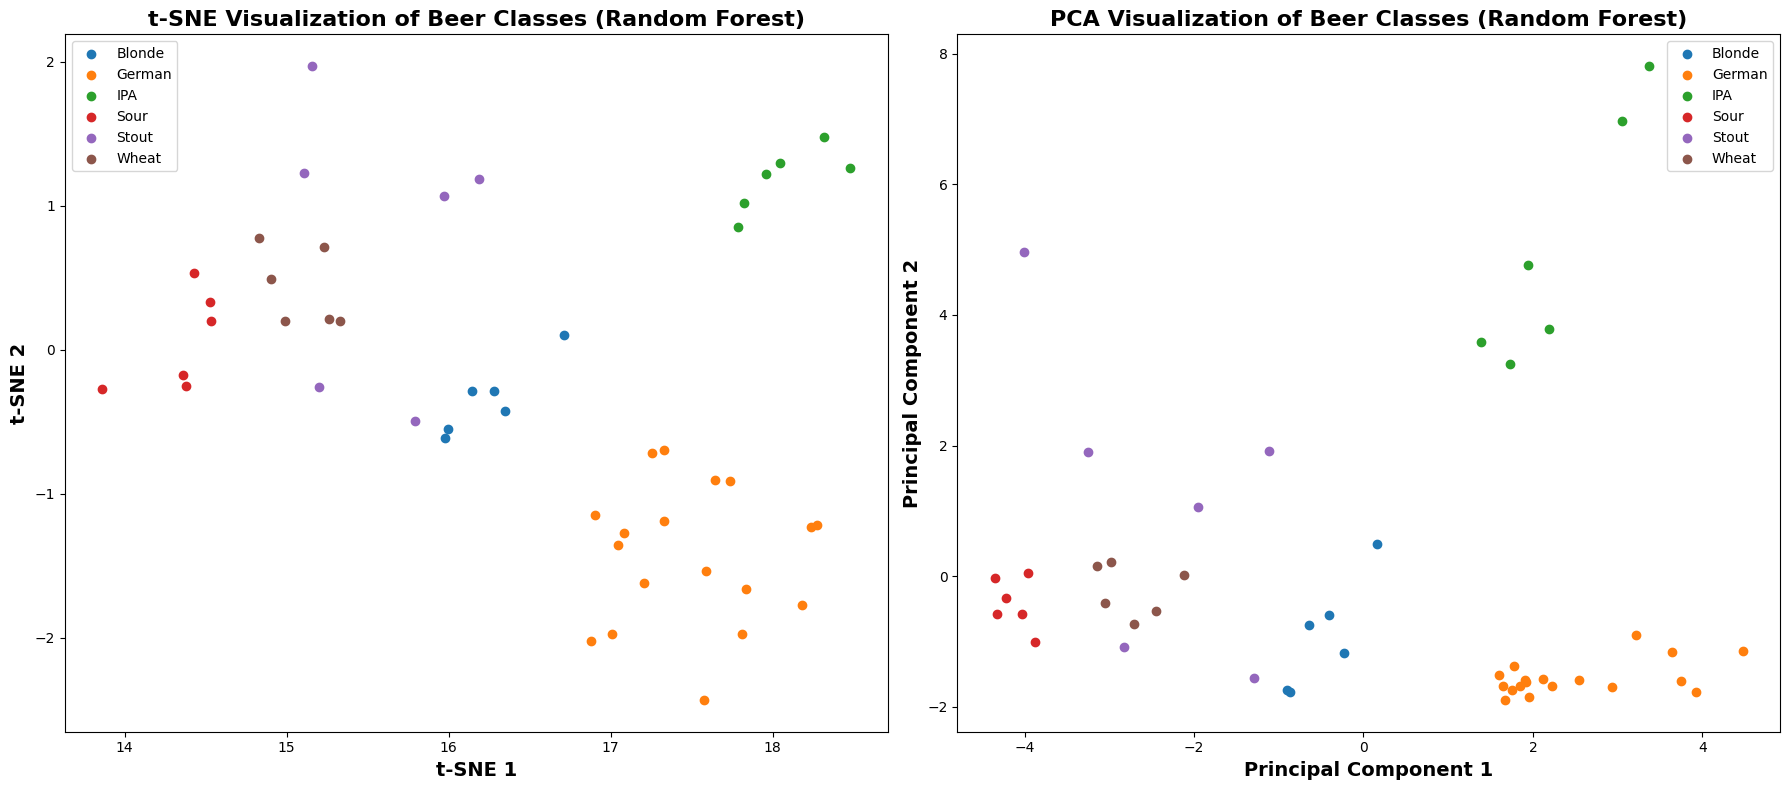

In [16]:
# Train Random Forest
def train_random_forest(X, y):
    rf_model = RandomForestClassifier(n_estimators=50, random_state=42)
    rf_model.fit(X, y)
    return rf_model

rf_model = train_random_forest(X_scaled, y)
rf_top_indices = np.argsort(rf_model.feature_importances_)[::-1][:20]
rf_top_features = beer.columns[:-1][rf_top_indices]
rf_top_importances = rf_model.feature_importances_[rf_top_indices]
display_top_features_table('Random Forest', rf_top_features, rf_top_importances)
plot_pca_tsne(X_scaled, y, rf_top_indices, 'Random Forest')


## XGboost

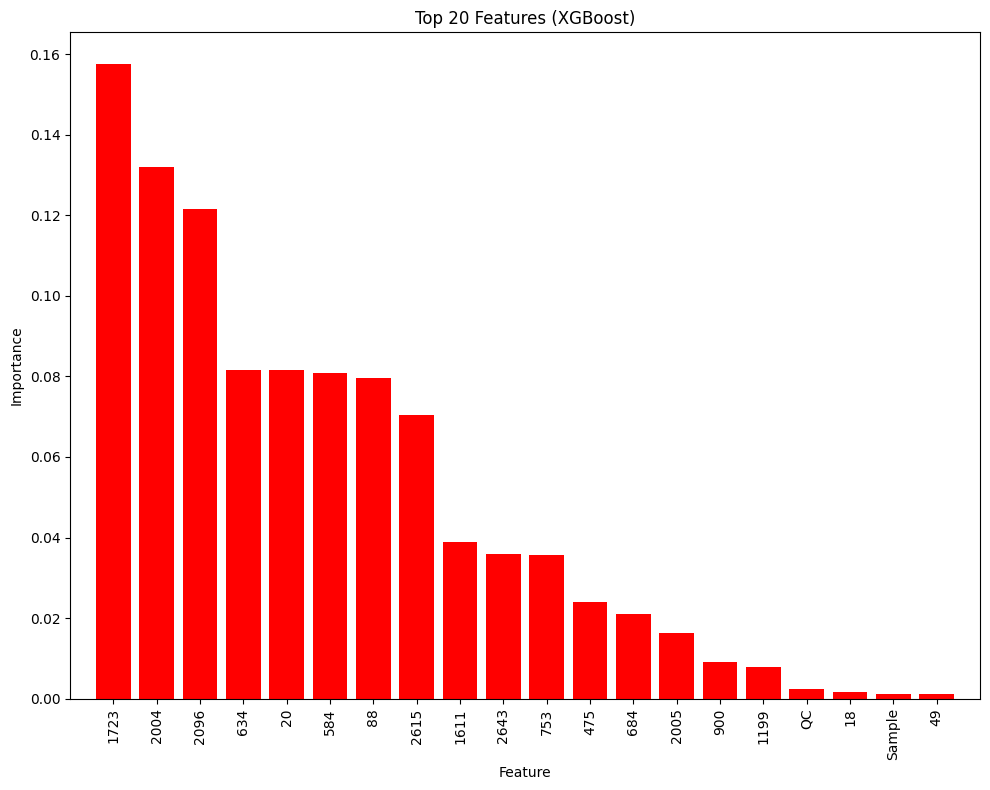

   Feature  Importance
0     1723    0.157567
1     2004    0.131929
2     2096    0.121576
3      634    0.081573
4       20    0.081520
5      584    0.080787
6       88    0.079547
7     2615    0.070465
8     1611    0.038972
9     2643    0.035952
10     753    0.035626
11     475    0.023927
12     684    0.021030
13    2005    0.016204
14     900    0.009194
15    1199    0.007856
16      QC    0.002427
17      18    0.001593
18  Sample    0.001179
19      49    0.001075


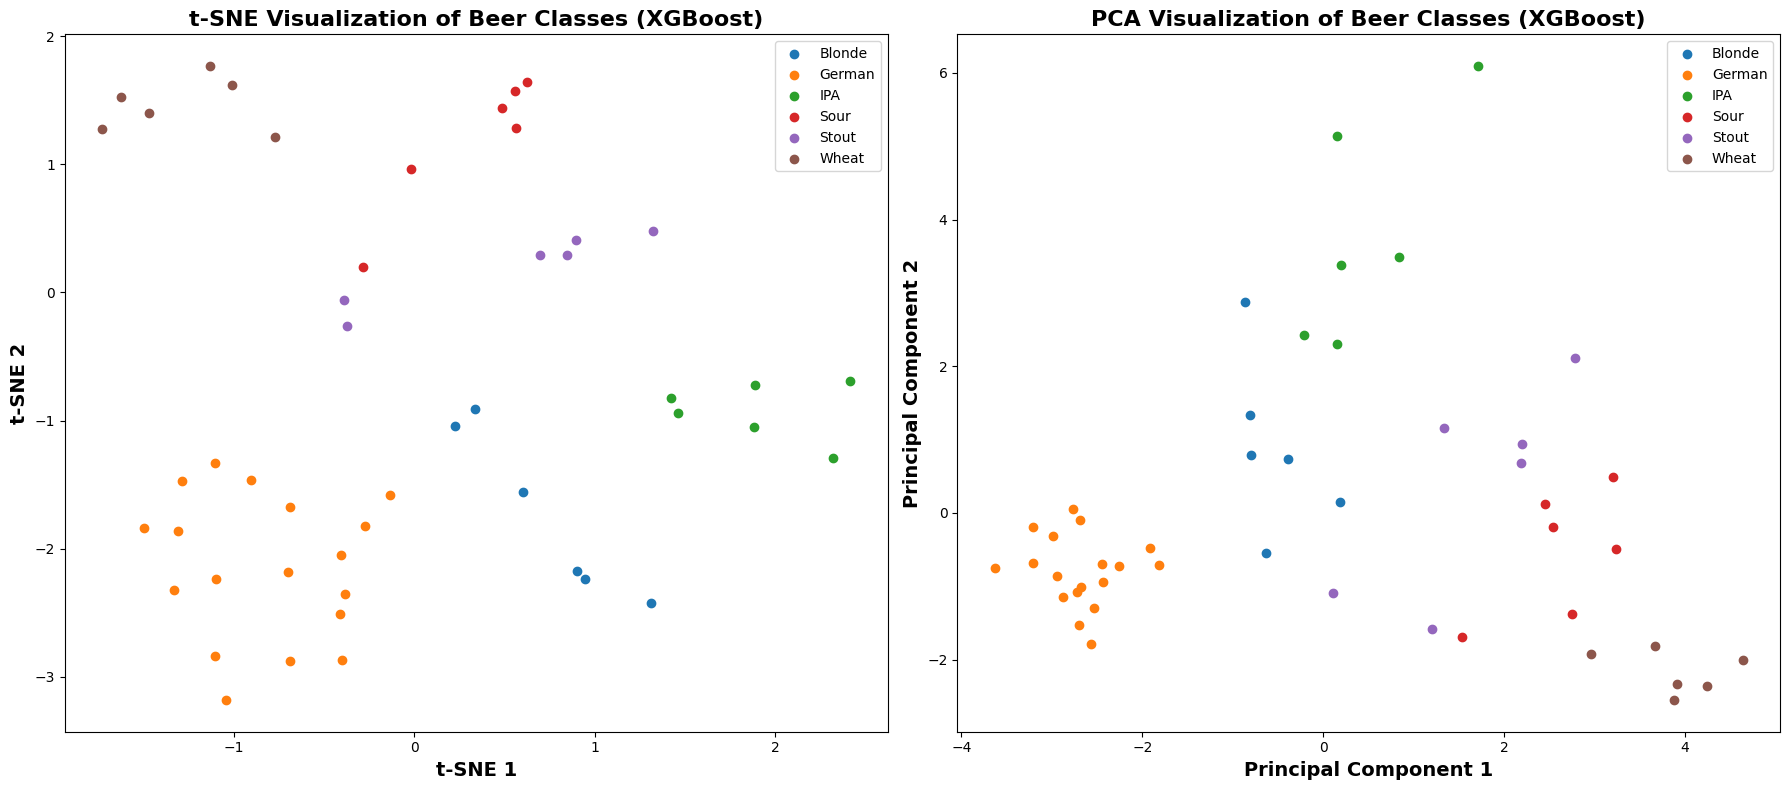

In [17]:
def train_xgboost(X, y):
    xgb_model = XGBClassifier(n_estimators=100, random_state=42)
    xgb_model.fit(X, y)
    return xgb_model

# Train XGBoost
xgb_model = train_xgboost(X_scaled, y)
xgb_top_indices = np.argsort(xgb_model.feature_importances_)[::-1][:20]
xgb_top_features = beer.columns[:-1][xgb_top_indices]
xgb_top_importances = xgb_model.feature_importances_[xgb_top_indices]
display_top_features_table('XGBoost', xgb_top_features, xgb_top_importances)
plot_pca_tsne(X_scaled, y, xgb_top_indices, 'XGBoost')


## LASSO

Total Variance Explained by PCA for LASSO: 0.47


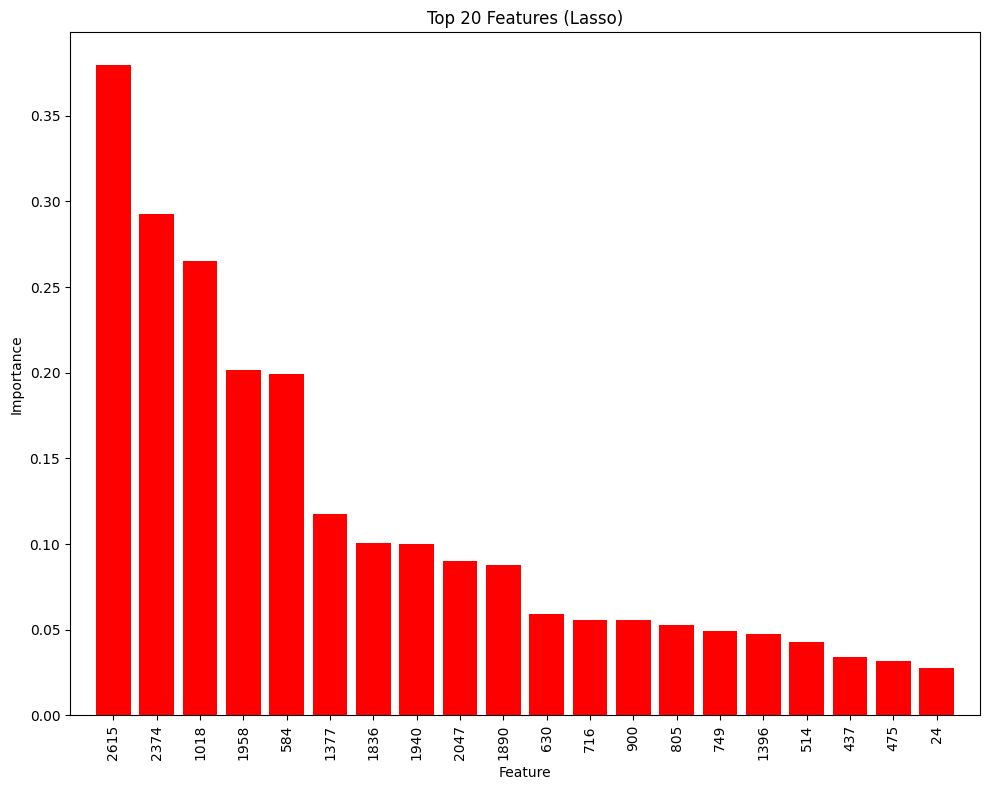

   Feature  Importance
0     2615    0.379691
1     2374    0.292771
2     1018    0.265475
3     1958    0.201706
4      584    0.199520
5     1377    0.117669
6     1836    0.100518
7     1940    0.100039
8     2047    0.090283
9     1890    0.087590
10     630    0.058936
11     716    0.055790
12     900    0.055610
13     805    0.052631
14     749    0.049063
15    1396    0.047699
16     514    0.042828
17     437    0.033886
18     475    0.031725
19      24    0.027904


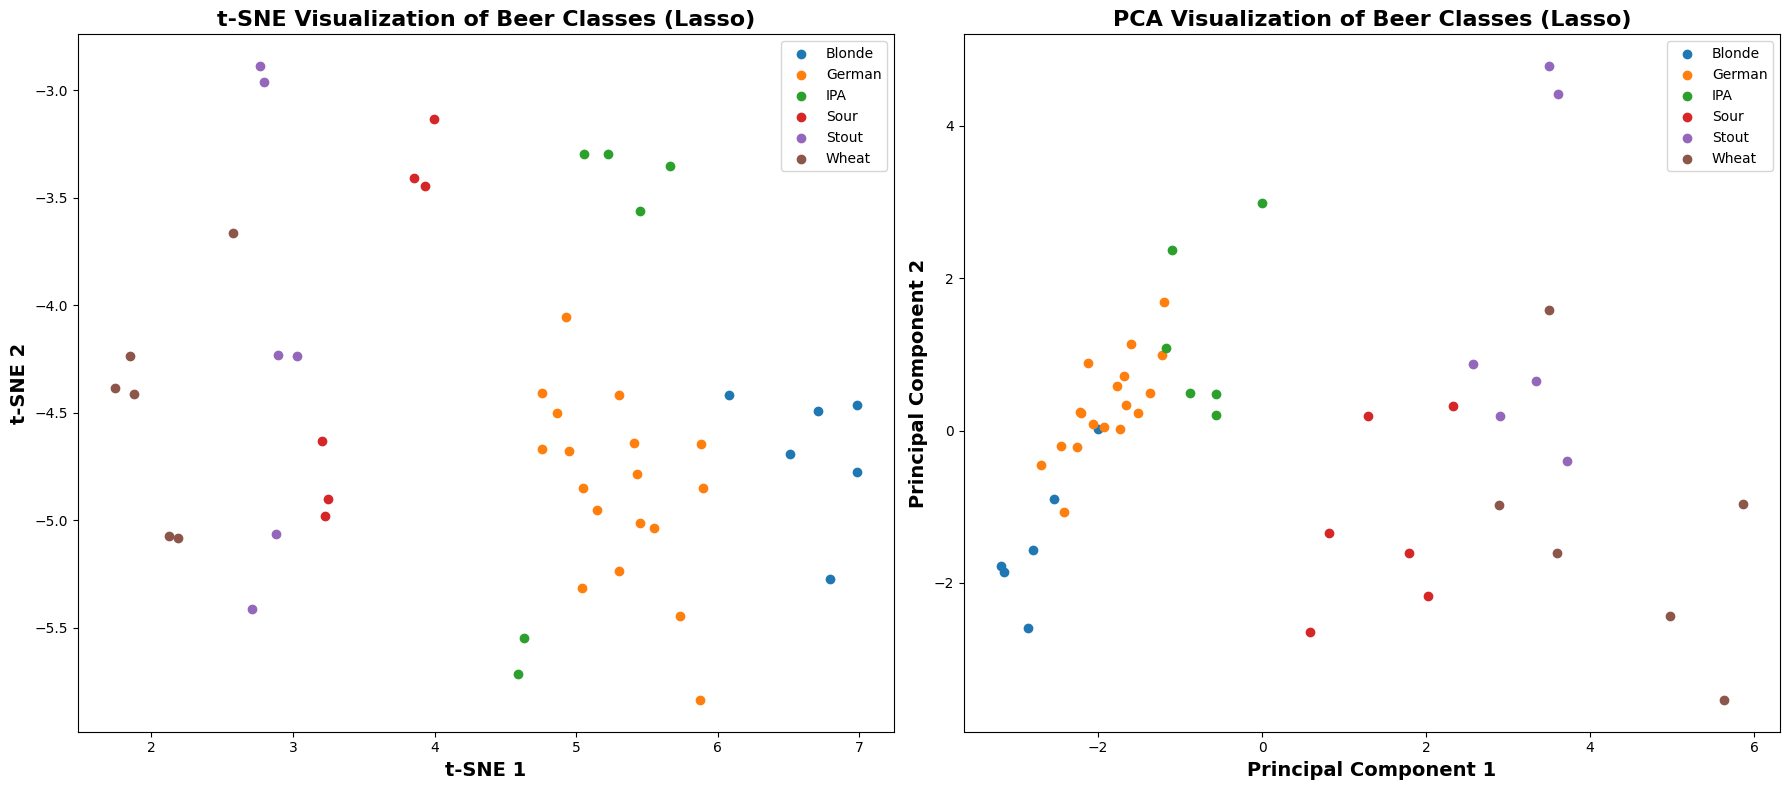

In [18]:
def train_lasso(X, y):
    lasso_model = Lasso(alpha=0.1, random_state=42)
    lasso_model.fit(X, y)
    return lasso_model

# Train LASSO
lasso_model = train_lasso(X_scaled, y)
lasso_top_indices = np.argsort(np.abs(lasso_model.coef_))[::-1][:20]
lasso_top_features = beer.columns[:-1][lasso_top_indices]
lasso_top_importances = np.abs(lasso_model.coef_)[lasso_top_indices]

# Select only the top features for PCA
X_top_features_lasso = X_scaled[:, lasso_top_indices]

# Perform PCA for LASSO
pca_lasso = PCA(n_components=2, random_state=42)
X_pca_lasso = pca_lasso.fit_transform(X_top_features_lasso)

# Calculate the total variance explained by PCA for LASSO
lasso_total_variance_explained = np.sum(pca_lasso.explained_variance_ratio_)

# Display the total variance explained by PCA for LASSO
print(f'Total Variance Explained by PCA for LASSO: {lasso_total_variance_explained:.2f}')

# Display top features table for LASSO
display_top_features_table('Lasso', lasso_top_features, lasso_top_importances)

# Plot PCA visualization for LASSO
plot_pca_tsne(X_scaled, y, lasso_top_indices, 'Lasso')


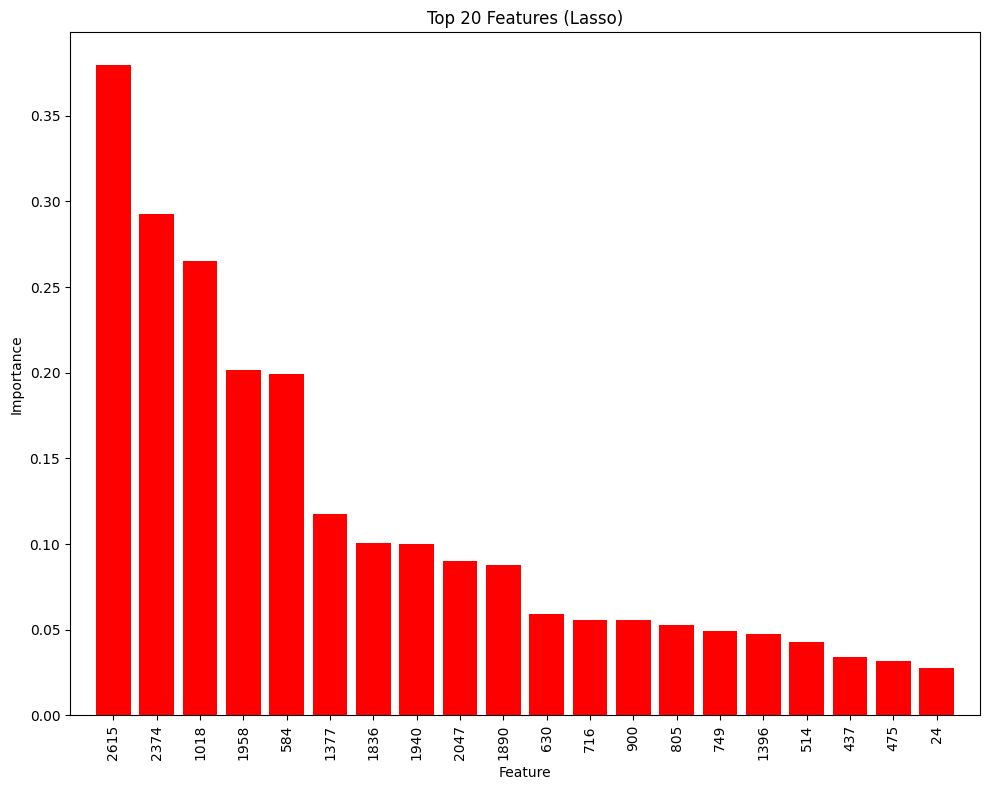

   Feature  Importance
0     2615    0.379691
1     2374    0.292771
2     1018    0.265475
3     1958    0.201706
4      584    0.199520
5     1377    0.117669
6     1836    0.100518
7     1940    0.100039
8     2047    0.090283
9     1890    0.087590
10     630    0.058936
11     716    0.055790
12     900    0.055610
13     805    0.052631
14     749    0.049063
15    1396    0.047699
16     514    0.042828
17     437    0.033886
18     475    0.031725
19      24    0.027904


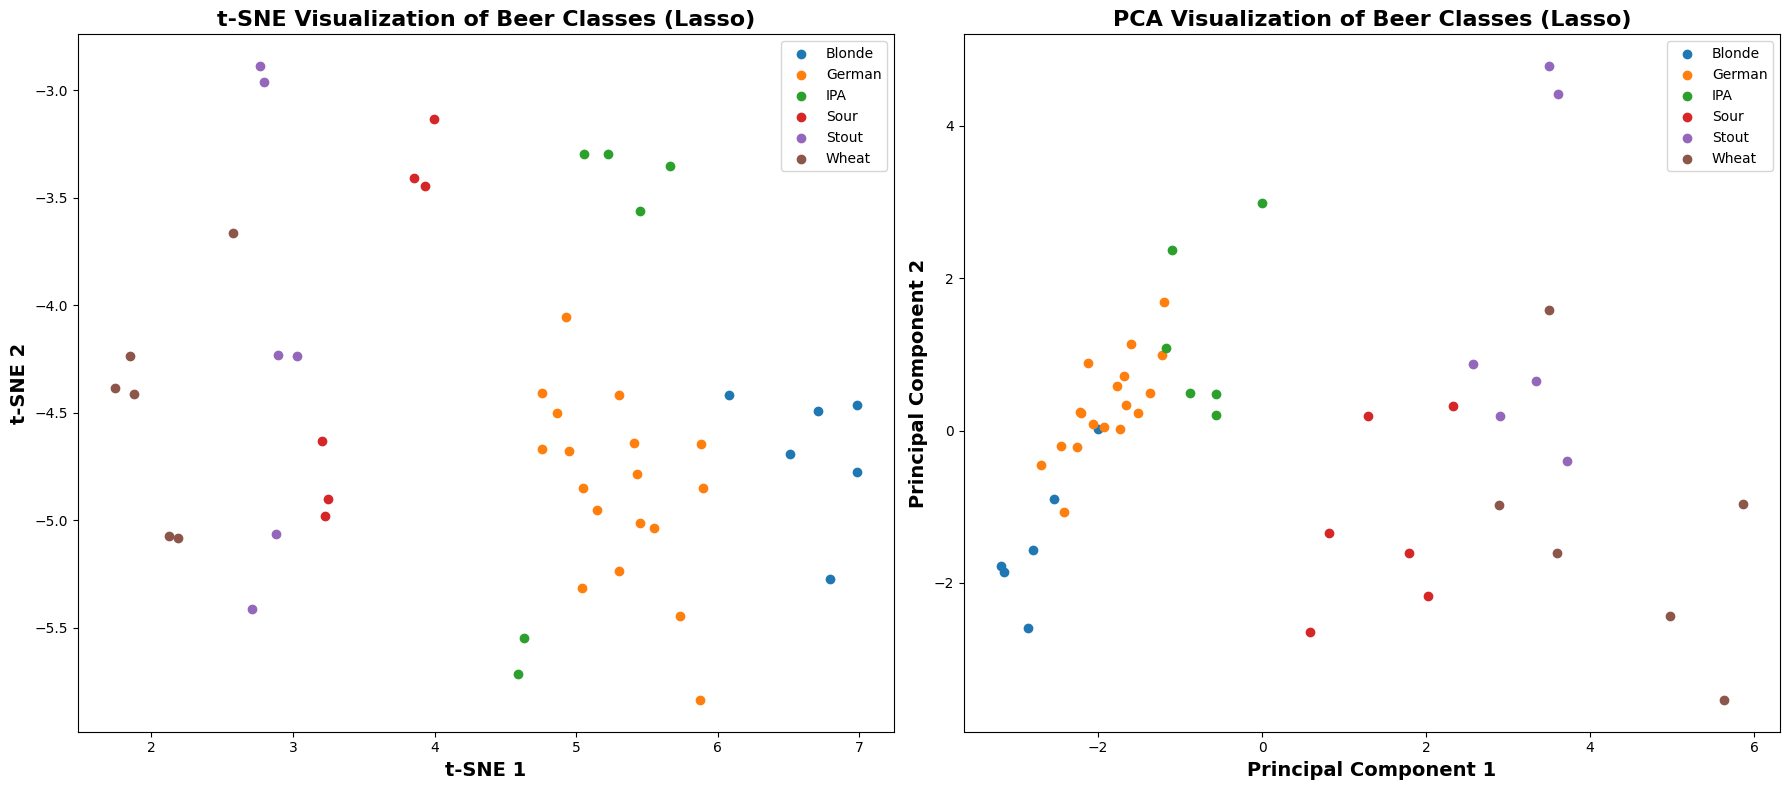

In [19]:
def train_lasso(X, y):
    lasso_model = Lasso(alpha=0.1, random_state=42)
    lasso_model.fit(X, y)
    return lasso_model

# Train Lasso
lasso_model = train_lasso(X_scaled, y)
lasso_top_indices = np.argsort(np.abs(lasso_model.coef_))[::-1][:20]
lasso_top_features = beer.columns[:-1][lasso_top_indices]
lasso_top_importances = np.abs(lasso_model.coef_)[lasso_top_indices]
display_top_features_table('Lasso', lasso_top_features, lasso_top_importances)
plot_pca_tsne(X_scaled, y, lasso_top_indices, 'Lasso')

## LightGBM

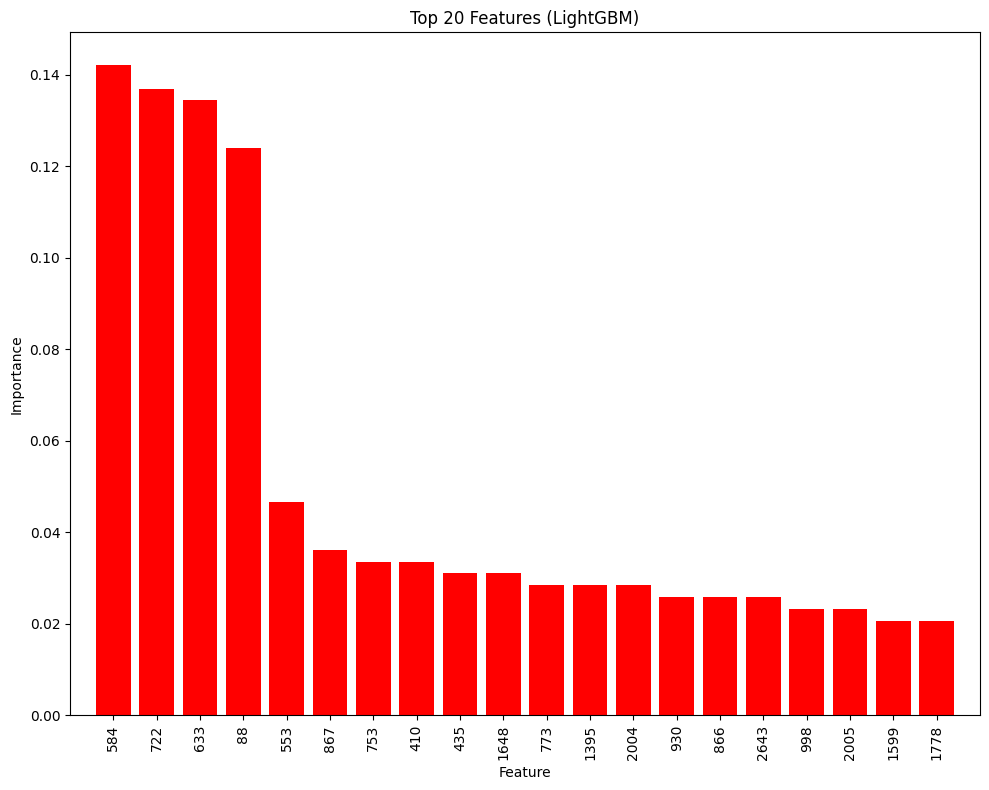

   Feature  Importance
0      584    0.142119
1      722    0.136951
2      633    0.134367
3       88    0.124031
4      553    0.046512
5      867    0.036176
6      753    0.033592
7      410    0.033592
8      435    0.031008
9     1648    0.031008
10     773    0.028424
11    1395    0.028424
12    2004    0.028424
13     930    0.025840
14     866    0.025840
15    2643    0.025840
16     998    0.023256
17    2005    0.023256
18    1599    0.020672
19    1778    0.020672


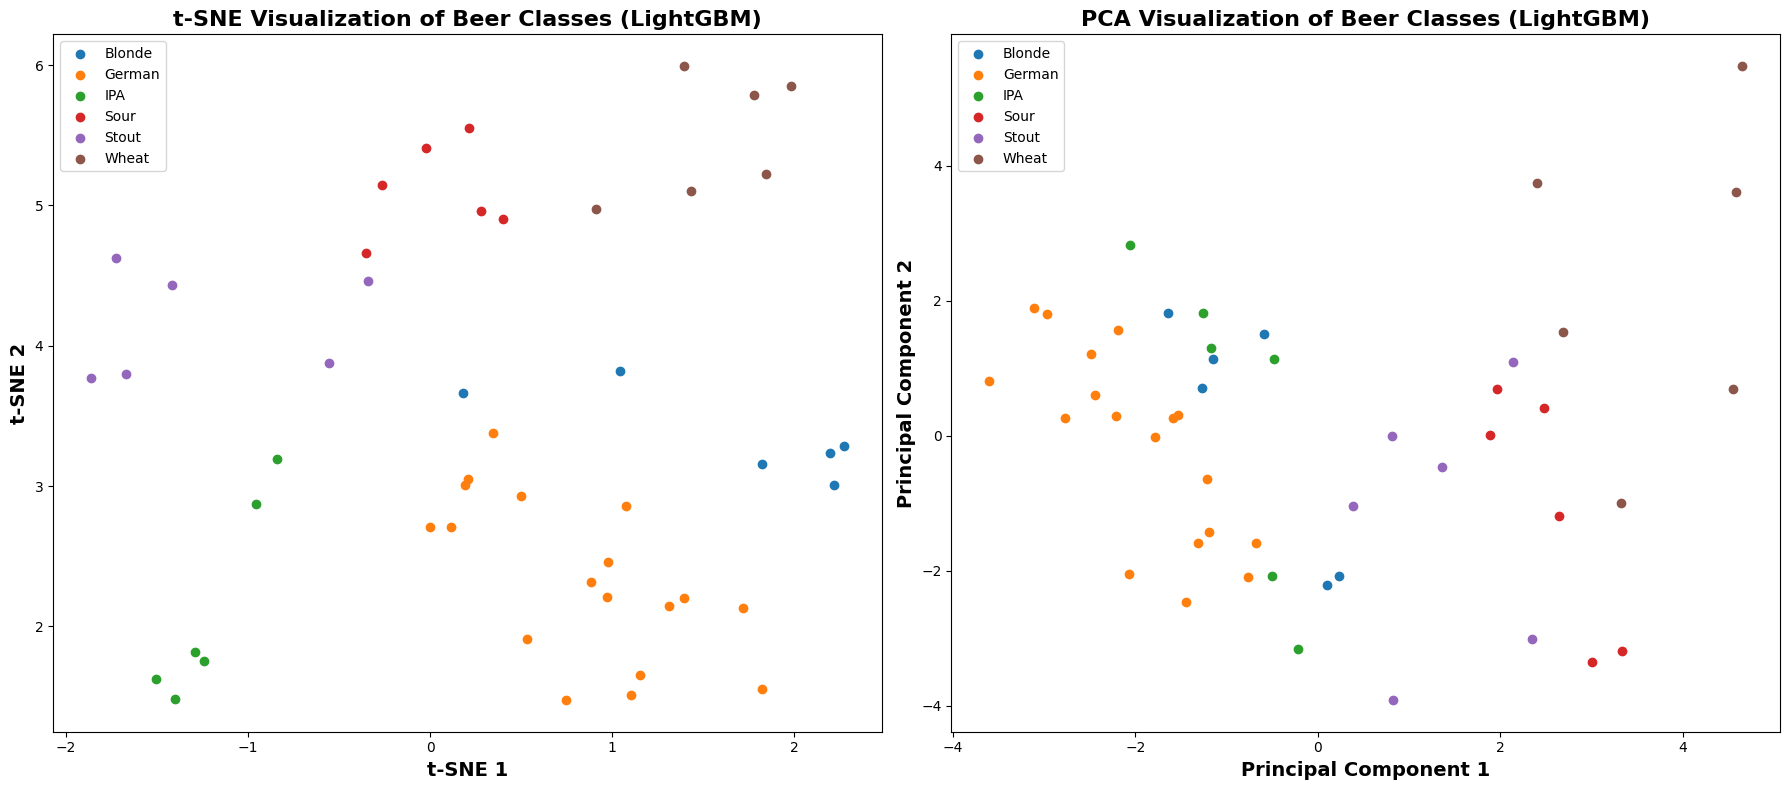

Total Variance Explained by PCA: 0.4449780304707542


In [20]:
def train_lightgbm(X, y):
    lgb_model = LGBMClassifier(n_estimators=100, random_state=42)
    lgb_model.fit(X, y)
    return lgb_model

# Train LightGBM
lgb_model = train_lightgbm(X_scaled, y)
lgb_top_indices = np.argsort(lgb_model.feature_importances_)[::-1][:20]
lgb_top_features = beer.columns[:-1][lgb_top_indices]
lgb_top_importances = lgb_model.feature_importances_[lgb_top_indices]

# Select only the top features for PCA
X_top_features = X_scaled[:, lgb_top_indices]

# Normalize the importances
lgb_top_importances_normalized = lgb_top_importances / np.sum(lgb_top_importances)

# Perform PCA
pca_lgb = PCA(n_components=2, random_state=42)
X_pca_lgb = pca_lgb.fit_transform(X_top_features)

# Calculate the total variance explained by the principal components
lgb_total_variance_explained = np.sum(pca_lgb.explained_variance_ratio_)

display_top_features_table('LightGBM', lgb_top_features, lgb_top_importances_normalized)
plot_pca_tsne(X_scaled, y, lgb_top_indices, 'LightGBM')

# Display the total variance explained
print("Total Variance Explained by PCA:", lgb_total_variance_explained)


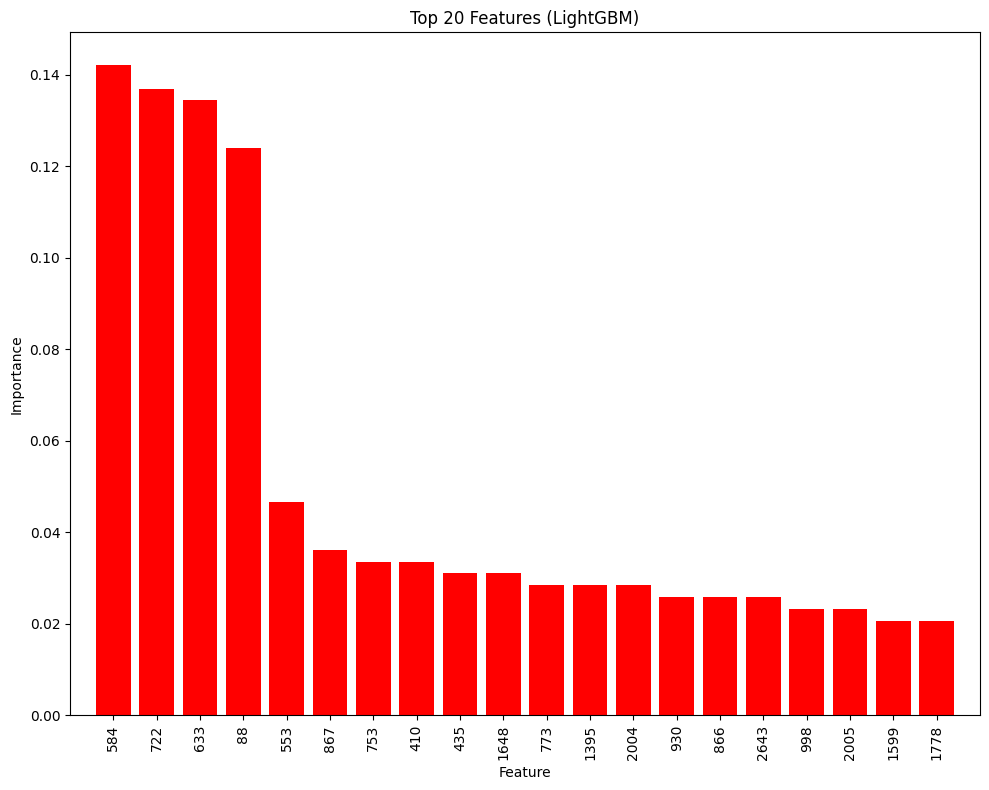

   Feature  Importance
0      584    0.142119
1      722    0.136951
2      633    0.134367
3       88    0.124031
4      553    0.046512
5      867    0.036176
6      753    0.033592
7      410    0.033592
8      435    0.031008
9     1648    0.031008
10     773    0.028424
11    1395    0.028424
12    2004    0.028424
13     930    0.025840
14     866    0.025840
15    2643    0.025840
16     998    0.023256
17    2005    0.023256
18    1599    0.020672
19    1778    0.020672


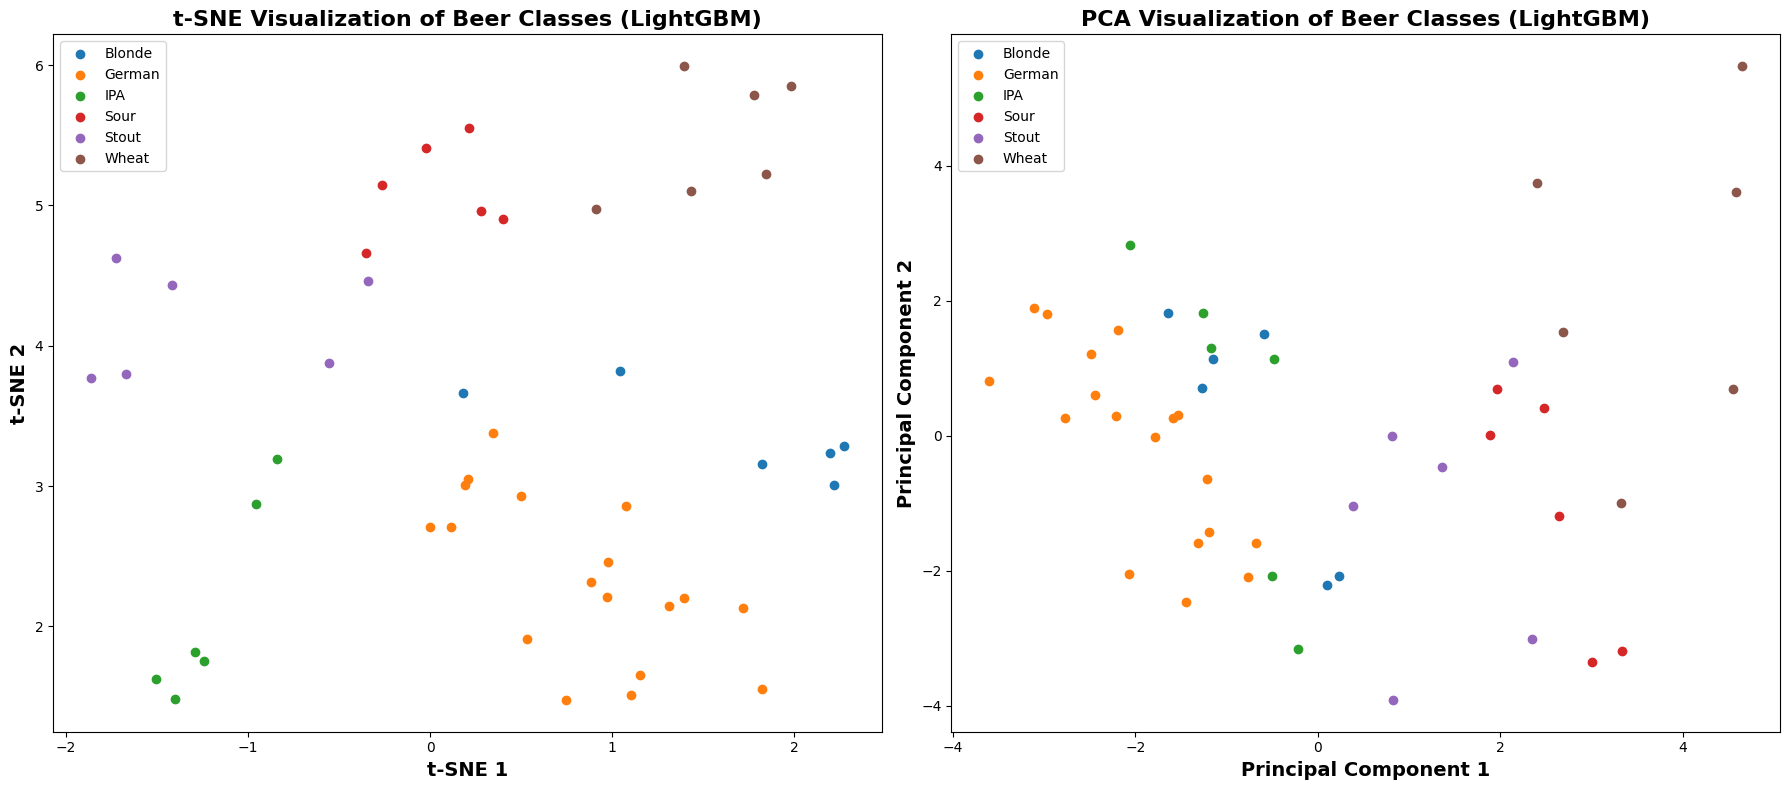

In [21]:
def train_lightgbm(X, y):
    lgb_model = LGBMClassifier(n_estimators=100, random_state=42)
    lgb_model.fit(X, y)
    return lgb_model

# Train LightGBM
lgb_model = train_lightgbm(X_scaled, y)
lgb_top_indices = np.argsort(lgb_model.feature_importances_)[::-1][:20]
lgb_top_features = beer.columns[:-1][lgb_top_indices]
lgb_top_importances = lgb_model.feature_importances_[lgb_top_indices]

# Normalize the importances
lgb_top_importances_normalized = lgb_top_importances / np.sum(lgb_top_importances)

display_top_features_table('LightGBM', lgb_top_features, lgb_top_importances_normalized)
plot_pca_tsne(X_scaled, y, lgb_top_indices, 'LightGBM')


## Gradient Boosting

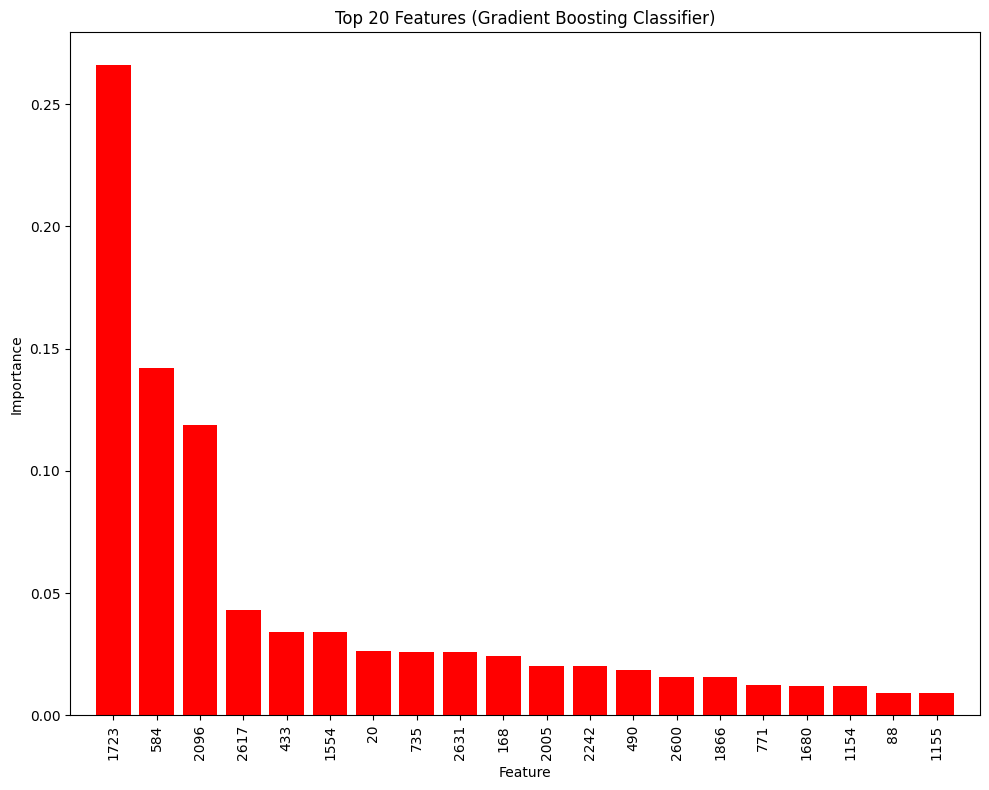

   Feature  Importance
0     1723    0.266096
1      584    0.141879
2     2096    0.118617
3     2617    0.043058
4      433    0.034044
5     1554    0.034044
6       20    0.026130
7      735    0.025947
8     2631    0.025947
9      168    0.024220
10    2005    0.020082
11    2242    0.020077
12     490    0.018372
13    2600    0.015450
14    1866    0.015450
15     771    0.012367
16    1680    0.011876
17    1154    0.011795
18      88    0.009045
19    1155    0.008933


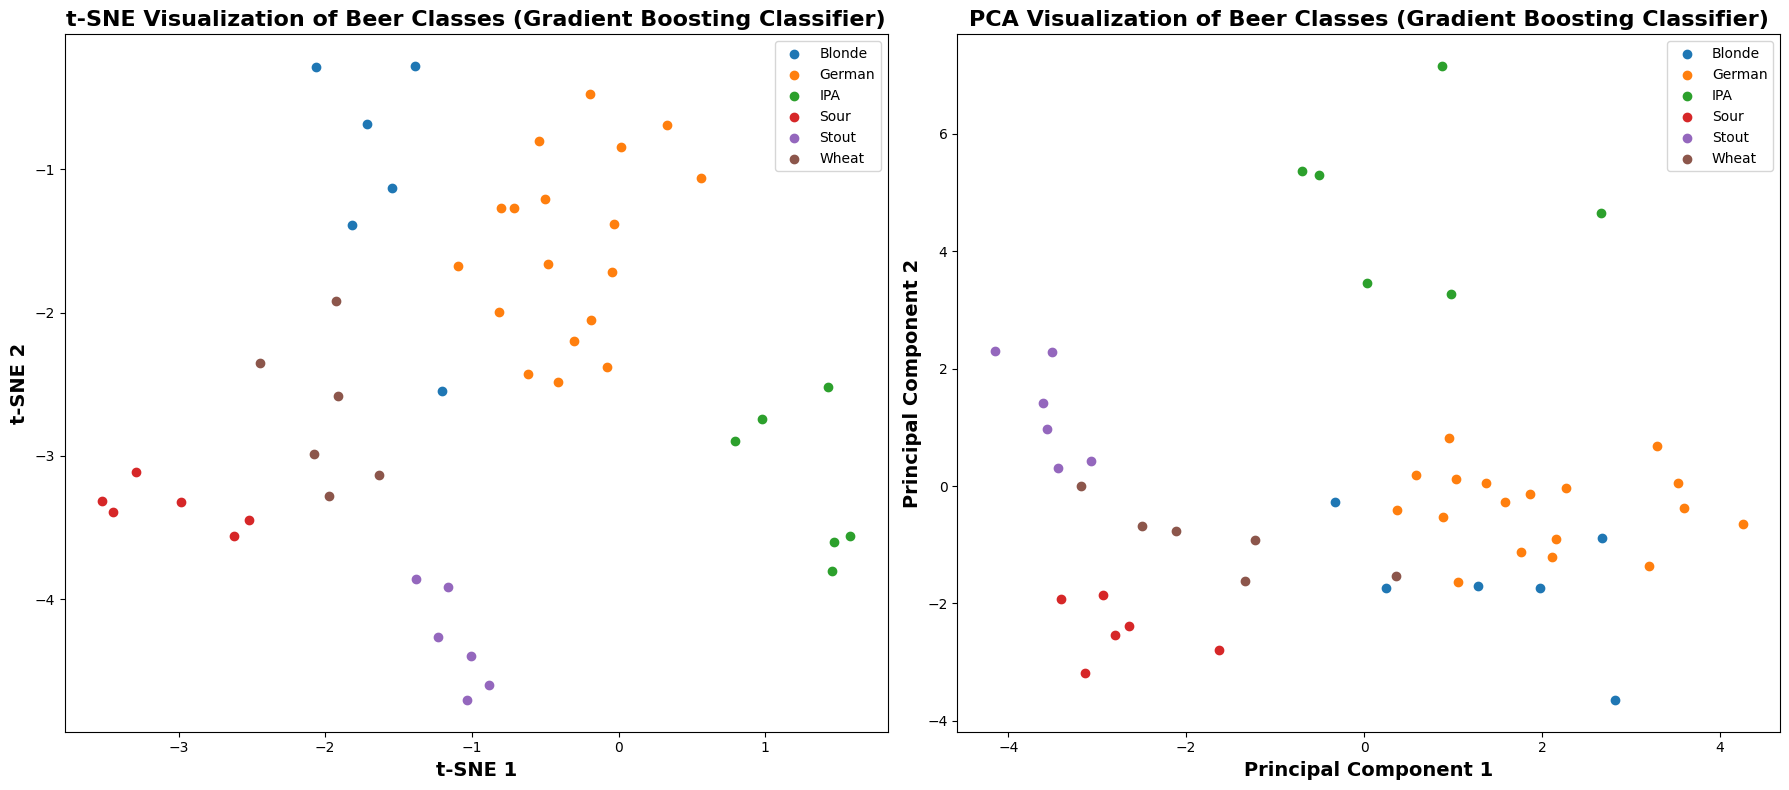

In [22]:
def train_gradient_boosting(X, y):
    gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
    gb_model.fit(X, y)
    return gb_model

# Train Gradient Boosting Classifier
gb_model = train_gradient_boosting(X_scaled, y)
gb_top_indices = np.argsort(gb_model.feature_importances_)[::-1][:20]
gb_top_features = beer.columns[:-1][gb_top_indices]
gb_top_importances = gb_model.feature_importances_[gb_top_indices]
display_top_features_table('Gradient Boosting Classifier', gb_top_features, gb_top_importances)
plot_pca_tsne(X_scaled, y, gb_top_indices, 'Gradient Boosting Classifier')

# 9. Evaluating the Models

- Checking how well each model preformed by looking at PCA to see how much variation in the beer data it could explain. The higher the variance, the better the features are at spearating beer types. 

### Variance explained by PCA

In [23]:
# Perform PCA for Random Forest
def calculate_pca_rf(X_scaled, rf_top_indices):
    # Select only the top features for PCA
    X_top_features_rf = X_scaled[:, rf_top_indices]
    
    # Initialize PCA
    pca_rf = PCA(n_components=2, random_state=42)
    
    # Fit PCA
    pca_rf.fit(X_top_features_rf)
    
    # Return the PCA object
    return pca_rf

# Calculate PCA for Random Forest
pca_rf = calculate_pca_rf(X_scaled, rf_top_indices)

# Calculate the total variance explained by PCA for Random Forest
rf_total_variance_explained = np.sum(pca_rf.explained_variance_ratio_)

# Print the total variance explained by PCA for Random Forest
print(f'Total Variance Explained by PCA for Random Forest: {rf_total_variance_explained:.2f}')


Total Variance Explained by PCA for Random Forest: 0.64


In [24]:
# Perform PCA for XGBoost
def calculate_pca_xgb(X_scaled, xgb_top_indices):
    # Select only the top features for PCA
    X_top_features_xgb = X_scaled[:, xgb_top_indices]
    
    # Initialize PCA
    pca_xgb = PCA(n_components=2, random_state=42)
    
    # Fit PCA
    pca_xgb.fit(X_top_features_xgb)
    
    # Return the PCA object
    return pca_xgb

# Calculate PCA for XGBoost
pca_xgb = calculate_pca_xgb(X_scaled, xgb_top_indices)

# Calculate the total variance explained by PCA for XGBoost
xgb_total_variance_explained = np.sum(pca_xgb.explained_variance_ratio_)

# Print the total variance explained by PCA for XGBoost
print(f'Total Variance Explained by PCA for XGBoost: {xgb_total_variance_explained:.2f}')


Total Variance Explained by PCA for XGBoost: 0.49


In [25]:
# Perform PCA for LASSO
def calculate_pca_lasso(X_scaled, lasso_top_indices):
    # Select only the top features for PCA
    X_top_features_lasso = X_scaled[:, lasso_top_indices]
    
    # Initialize PCA
    pca_lasso = PCA(n_components=2, random_state=42)
    
    # Fit PCA
    pca_lasso.fit(X_top_features_lasso)
    
    # Return the PCA object
    return pca_lasso

# Calculate PCA for LASSO
pca_lasso = calculate_pca_lasso(X_scaled, lasso_top_indices)

# Calculate the total variance explained by PCA for LASSO
lasso_total_variance_explained = np.sum(pca_lasso.explained_variance_ratio_)

# Print the total variance explained by PCA for LASSO
print(f'Total Variance Explained by PCA for LASSO: {lasso_total_variance_explained:.2f}')


Total Variance Explained by PCA for LASSO: 0.47


In [26]:
# Perform PCA for LightGBM
def calculate_pca_lgb(X_scaled, lgb_top_indices):
    # Select only the top features for PCA
    X_top_features_lgb = X_scaled[:, lgb_top_indices]
    
    # Initialize PCA
    pca_lgb = PCA(n_components=2, random_state=42)
    
    # Fit PCA
    pca_lgb.fit(X_top_features_lgb)
    
    # Return the PCA object
    return pca_lgb

# Calculate PCA for LightGBM
pca_lgb = calculate_pca_lgb(X_scaled, lgb_top_indices)

# Calculate the total variance explained by PCA for LightGBM
lgb_total_variance_explained = np.sum(pca_lgb.explained_variance_ratio_)

# Print the total variance explained by PCA for LightGBM
print(f'Total Variance Explained by PCA for LightGBM: {lgb_total_variance_explained:.2f}')


Total Variance Explained by PCA for LightGBM: 0.44


In [27]:
# Perform PCA for Gradient Boosting Classifier
def calculate_pca_gb(X_scaled, gb_top_indices):
    # Select only the top features for PCA
    X_top_features_gb = X_scaled[:, gb_top_indices]
    
    # Initialize PCA
    pca_gb = PCA(n_components=2, random_state=42)
    
    # Fit PCA
    pca_gb.fit(X_top_features_gb)
    
    # Return the PCA object
    return pca_gb

# Calculate PCA for Gradient Boosting Classifier
pca_gb = calculate_pca_gb(X_scaled, gb_top_indices)

# Calculate the total variance explained by PCA for Gradient Boosting Classifier
gb_total_variance_explained = np.sum(pca_gb.explained_variance_ratio_)

# Print the total variance explained by PCA for Gradient Boosting Classifier
print(f'Total Variance Explained by PCA for Gradient Boosting Classifier: {gb_total_variance_explained:.2f}')


Total Variance Explained by PCA for Gradient Boosting Classifier: 0.54


In [28]:
# Calculate the total variance explained by PCA for LightGBM
lgb_total_variance_explained = np.sum(pca_lgb.explained_variance_ratio_)

# Add to the list of total variation explained by PCA
pca_total_variation_explained = [rf_total_variance_explained, xgb_total_variance_explained,
                                 lasso_total_variance_explained, lgb_total_variance_explained, gb_total_variance_explained]

# Add the names of the models
models = ['Random Forest', 'XGBoost', 'LASSO', 'LightGBM', 'Gradient Boosting Classifier']

# Print the total variation explained by PCA for each model
for model, pca_variance in zip(models, pca_total_variation_explained):
    print(f'Total Variance Explained by PCA for {model}: {pca_variance:.2f}')


Total Variance Explained by PCA for Random Forest: 0.64
Total Variance Explained by PCA for XGBoost: 0.49
Total Variance Explained by PCA for LASSO: 0.47
Total Variance Explained by PCA for LightGBM: 0.44
Total Variance Explained by PCA for Gradient Boosting Classifier: 0.54


# 10. Cross - Validation for Reliable Performance
- Instead of testing the models one, using the K-Fold Cross-Validation technique to test them multiple times on different parts of the data.
- Splitting the dataset into 5 smalller groups (folds)
- Each model was trained on 4 folds and tested on the 5th fold
- This process was repeated 5 times so every part of the data was tested
- Calculating the average accuracy and the variation in accuracy

This is all to ensure that the models were not just working well on one dataset but were actually reliabel when applied to raw data

### K fold cross validation

In [29]:
from sklearn.model_selection import KFold, cross_val_score

n_folds = 5
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

models = {
    'Random Forest': rf_model,
    'XGBoost': xgb_model,
    'Lasso': lasso_model,
    'LightGBM': lgb_model,
    'Gradient Boosting Classifier': gb_model
}

for model_name, model in models.items():
    cv_scores = cross_val_score(model, X_scaled, y, cv=kf)
    print(f"Cross-Validation Scores ({model_name}):", cv_scores)    
    print(f"Mean CV Score ({model_name}):", np.mean(cv_scores))
    print(f"Standard Deviation of CV Scores ({model_name}):", np.std(cv_scores))
    print()


Cross-Validation Scores (Random Forest): [0.8 0.8 0.7 1.  1. ]
Mean CV Score (Random Forest): 0.86
Standard Deviation of CV Scores (Random Forest): 0.12000000000000001

Cross-Validation Scores (XGBoost): [0.6        0.8        0.5        1.         0.88888889]
Mean CV Score (XGBoost): 0.7577777777777778
Standard Deviation of CV Scores (XGBoost): 0.18384104782174607

Cross-Validation Scores (Lasso): [0.92763079 0.76519374 0.64409641 0.87738953 0.81157337]
Mean CV Score (Lasso): 0.8051767678581332
Standard Deviation of CV Scores (Lasso): 0.09777127797139028

Cross-Validation Scores (LightGBM): [0.3        0.3        0.2        0.55555556 0.55555556]
Mean CV Score (LightGBM): 0.38222222222222224
Standard Deviation of CV Scores (LightGBM): 0.14616074357693642

Cross-Validation Scores (Gradient Boosting Classifier): [0.8        0.9        0.4        1.         0.88888889]
Mean CV Score (Gradient Boosting Classifier): 0.7977777777777778
Standard Deviation of CV Scores (Gradient Boosting Clas

# 11. Checking How Models Agree on Important Features

Each Model ranked different features as 'important' for classifying beers.
- Collecting the top features from each table to create a table where each column represented a model and each row represented a feature's importance score. Then calculating the correlation matrix, which tells us how similar the rankings are between the model
- Using a heatmap to viualize the correlation
- High correlation means the two models agreed on which features were most important
- Low correlation smeans the two models focused on different features

### Correlation Matrix

In [30]:
import numpy as np

# Extract top features for each model
top_importances = {
    'Random Forest': rf_top_importances,
    'XGBoost': xgb_top_importances,
    'Lasso': lasso_top_importances,
    'LightGBM': lgb_top_importances,
    'Gradient Boosting': gb_top_importances
}

# Concatenate top features into a single DataFrame
top_features_df = pd.DataFrame(index=range(len(top_importances['Random Forest'])))
for model_name, importances in top_importances.items():
    top_features_df[model_name] = importances

# Calculate correlation matrix
correlation_matrix = top_features_df.corr()

# Display correlation matrix
print(correlation_matrix)


                   Random Forest   XGBoost     Lasso  LightGBM  \
Random Forest           1.000000  0.972102  0.970382  0.914811   
XGBoost                 0.972102  1.000000  0.950972  0.859966   
Lasso                   0.970382  0.950972  1.000000  0.934023   
LightGBM                0.914811  0.859966  0.934023  1.000000   
Gradient Boosting       0.824519  0.836589  0.912718  0.845528   

                   Gradient Boosting  
Random Forest               0.824519  
XGBoost                     0.836589  
Lasso                       0.912718  
LightGBM                    0.845528  
Gradient Boosting           1.000000  


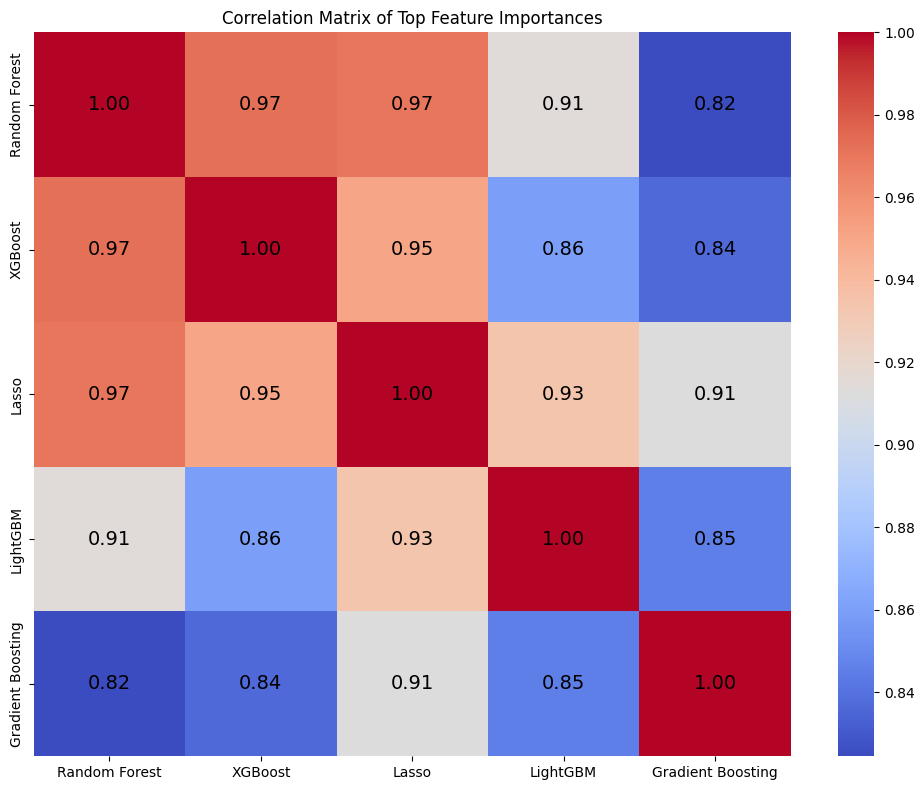

In [31]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 14, "color": 'black'})
plt.title('Correlation Matrix of Top Feature Importances')
plt.tight_layout()
plt.show()

# -------------------------------------------------------------------

# Venn Diagrams
We’re looking at which features different models think are important by comparing them in pairs. For each pair, we create a Venn diagram that shows where they agree (overlap) on which features to use. If they agree, we print out those features.

Overlap between Random Forest and XGBoost: 1611, 2004, 753


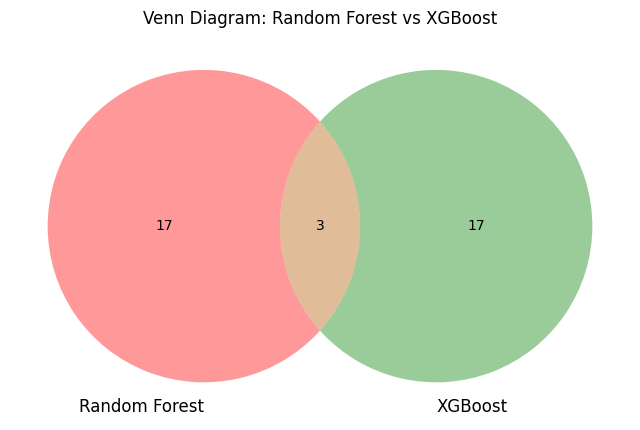

No overlap between Random Forest and Lasso


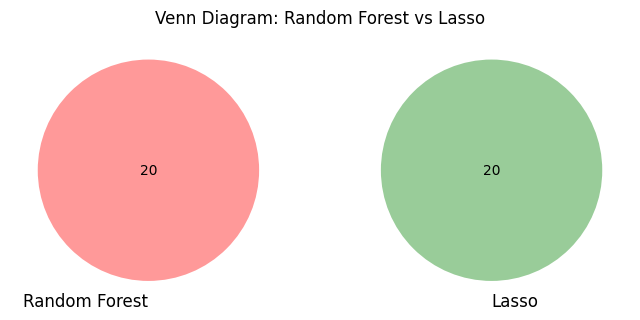

Overlap between Random Forest and LightGBM: 2004, 753


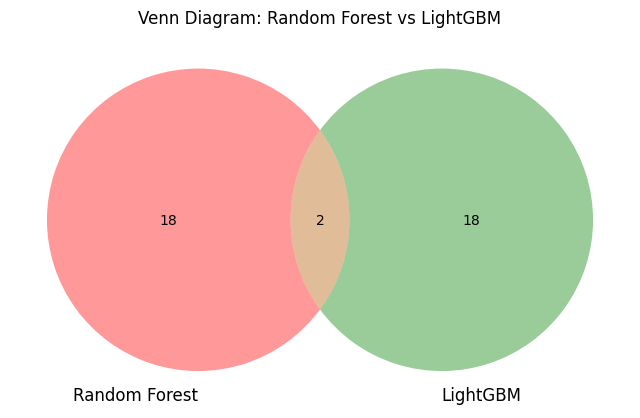

No overlap between Random Forest and Gradient Boosting


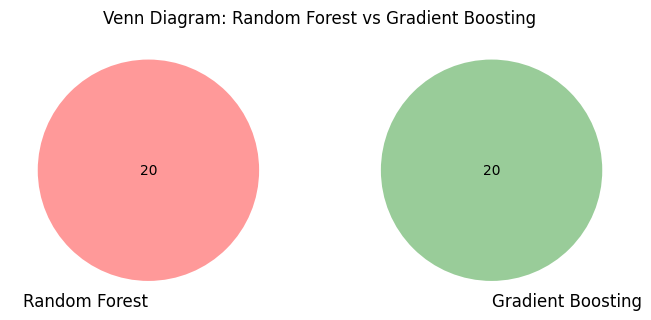

Overlap between XGBoost and Lasso: 2615, 475, 584, 900


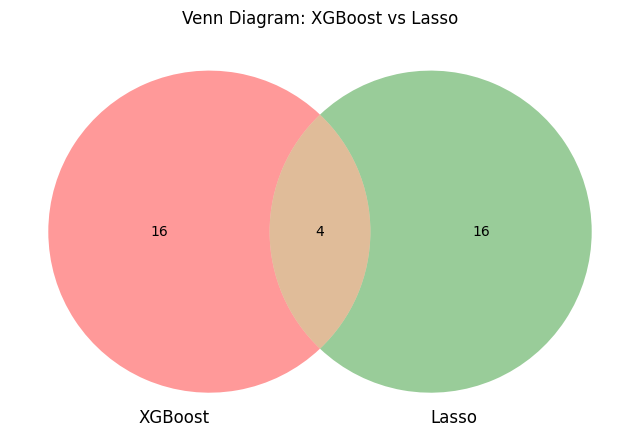

Overlap between XGBoost and LightGBM: 2004, 2005, 2643, 584, 753, 88


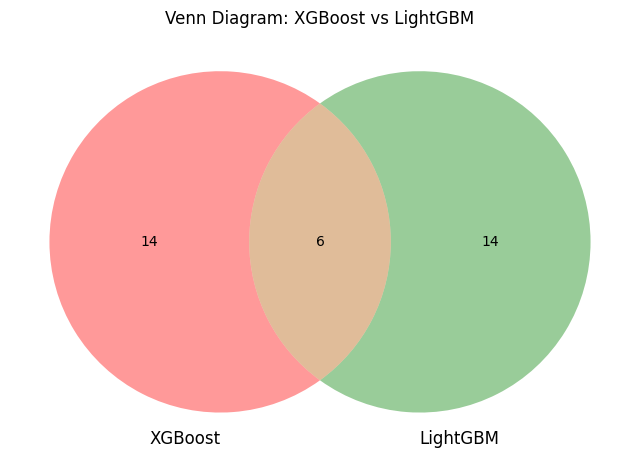

Overlap between XGBoost and Gradient Boosting: 1723, 20, 2005, 2096, 584, 88


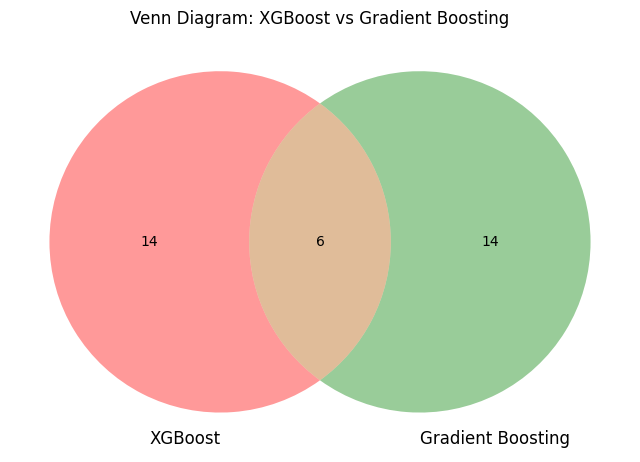

Overlap between Lasso and LightGBM: 584


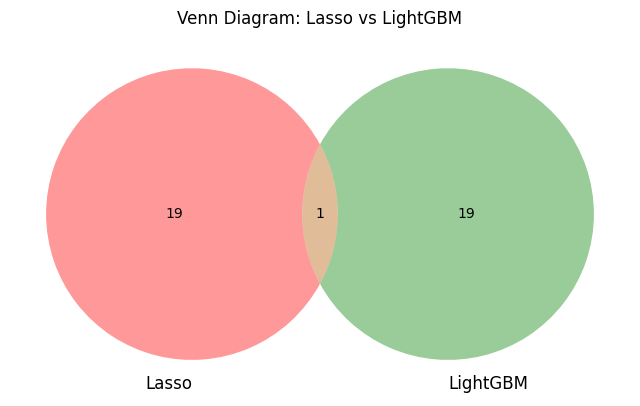

Overlap between Lasso and Gradient Boosting: 584


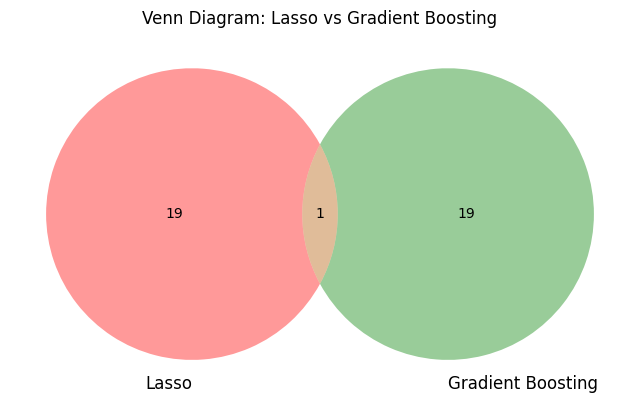

Overlap between LightGBM and Gradient Boosting: 2005, 584, 88


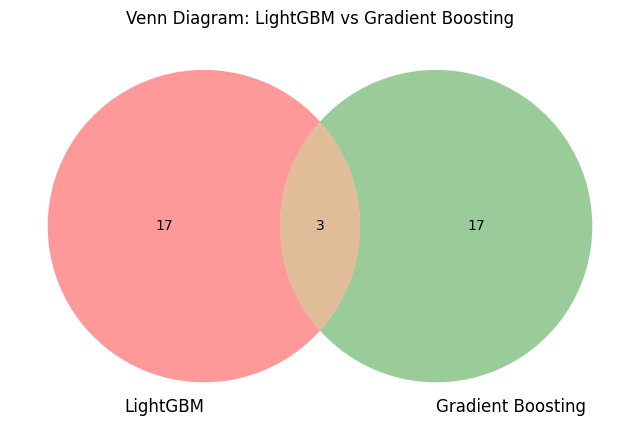

In [36]:
from matplotlib_venn import venn2

# Clean and standardize feature names to strings
rf_top_features_clean = [str(feature) for feature in ['1206', '1072', '1987', '1145', '2548', '1942', '1611', '1039', '1517', '1042', '2004', '366', '1679', '1402', '664', '2032', '1177', '2051', '753', '1182']]
xgb_top_features_clean = [str(feature) for feature in ['1723', '2004', '2096', '634', '20', '584', '88', '2615', '1611', '2643', '753', '475', '684', '2005', '900', '1199', 'QC', '18', 'Sample', '49']]
lasso_top_features_clean = [str(feature) for feature in ['2615', '2374', '1018', '1958', '584', '1377', '1836', '1940', '2047', '1890', '630', '716', '900', '805', '749', '1396', '514', '437', '475', '24']]
lgb_top_features_clean = [str(feature) for feature in ['584', '722', '633', '88', '553', '867', '753', '410', '435', '1648', '773', '1395', '2004', '930', '866', '2643', '998', '2005', '1599', '1778']]
gb_top_features_clean = [str(feature) for feature in ['1723', '584', '2096', '2617', '433', '1554', '20', '735', '2631', '168', '2005', '2242', '490', '2600', '1866', '771', '1680', '1154', '88', '1155']]

# Convert top features to sets for each model
rf_top_features_set = set(rf_top_features_clean)
xgb_top_features_set = set(xgb_top_features_clean)
lasso_top_features_set = set(lasso_top_features_clean)
lgb_top_features_set = set(lgb_top_features_clean)
gb_top_features_set = set(gb_top_features_clean)

# Pairwise Venn diagrams
model_pairs = [
    ('Random Forest', 'XGBoost', rf_top_features_set, xgb_top_features_set),
    ('Random Forest', 'Lasso', rf_top_features_set, lasso_top_features_set),
    ('Random Forest', 'LightGBM', rf_top_features_set, lgb_top_features_set),
    ('Random Forest', 'Gradient Boosting', rf_top_features_set, gb_top_features_set),
    ('XGBoost', 'Lasso', xgb_top_features_set, lasso_top_features_set),
    ('XGBoost', 'LightGBM', xgb_top_features_set, lgb_top_features_set),
    ('XGBoost', 'Gradient Boosting', xgb_top_features_set, gb_top_features_set),
    ('Lasso', 'LightGBM', lasso_top_features_set, lgb_top_features_set),
    ('Lasso', 'Gradient Boosting', lasso_top_features_set, gb_top_features_set),
    ('LightGBM', 'Gradient Boosting', lgb_top_features_set, gb_top_features_set)
]

# Generate Venn diagrams for each pair of models
for model1, model2, set1, set2 in model_pairs:
    plt.figure(figsize=(8, 6))
    
    # Generate the Venn diagram
    venn = venn2([set1, set2], set_labels=(model1, model2))
    
    # Find overlap (intersection) between the two sets
    overlap = set1.intersection(set2)
    
    if overlap:
        print(f"Overlap between {model1} and {model2}: {', '.join(sorted(overlap))}")
    else:
        print(f"No overlap between {model1} and {model2}")
    
    # Display the Venn diagram
    plt.title(f"Venn Diagram: {model1} vs {model2}")
    plt.show()


Overlap between Random Forest and XGBoost: 1611, 2004, 753


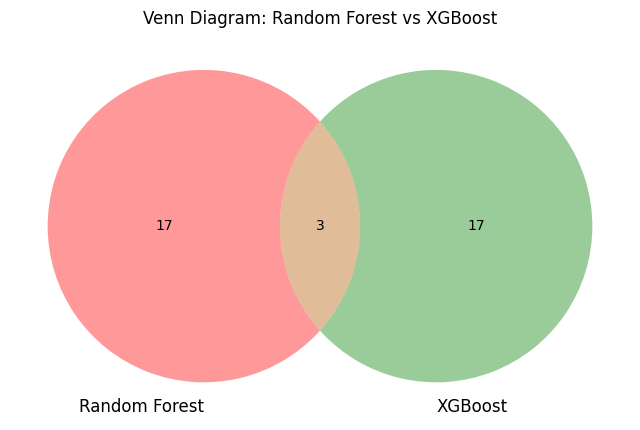

No overlap between Random Forest and Lasso


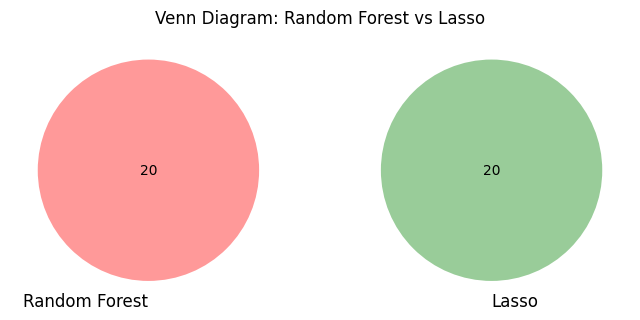

Overlap between Random Forest and LightGBM: 2004, 753


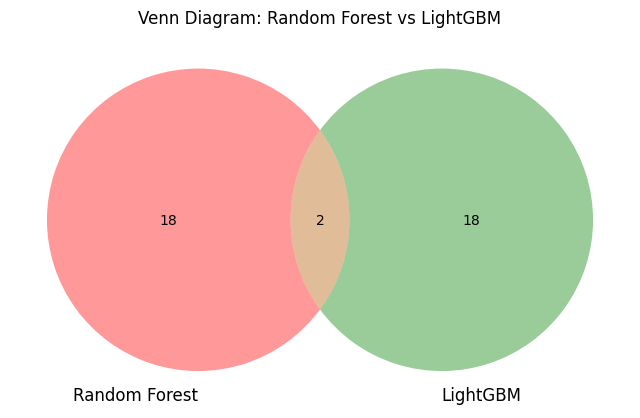

No overlap between Random Forest and Gradient Boosting


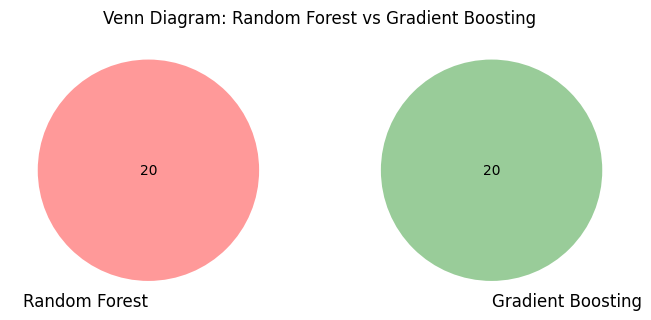

Overlap between XGBoost and Lasso: 2615, 475, 584, 900


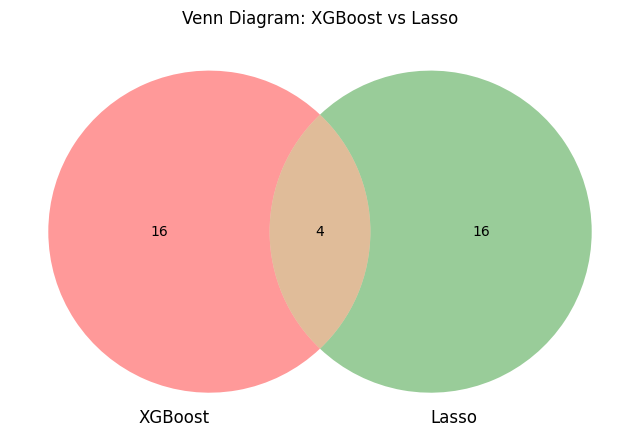

Overlap between XGBoost and LightGBM: 2004, 2005, 2643, 584, 753, 88


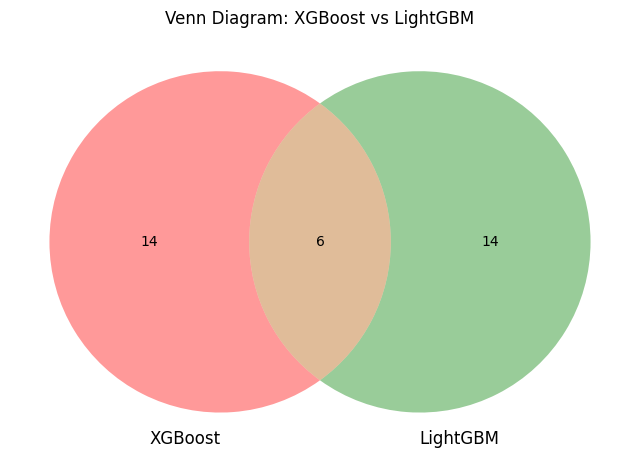

Overlap between XGBoost and Gradient Boosting: 1723, 20, 2005, 2096, 584, 88


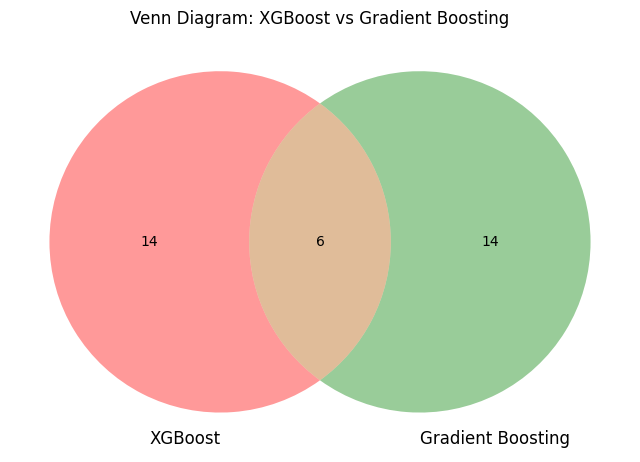

Overlap between Lasso and LightGBM: 584


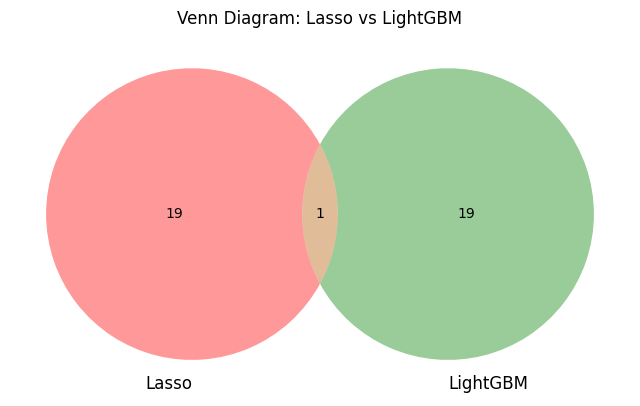

Overlap between Lasso and Gradient Boosting: 584


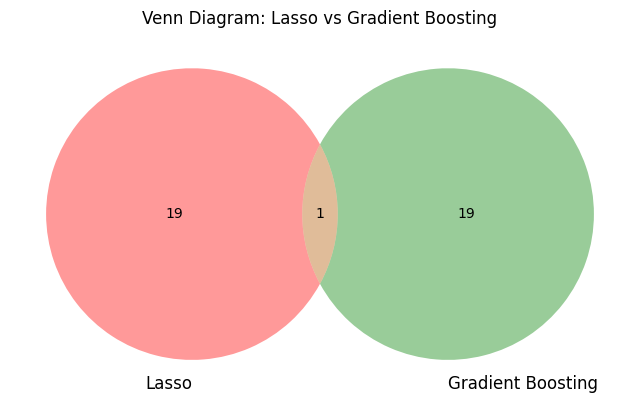

Overlap between LightGBM and Gradient Boosting: 2005, 584, 88


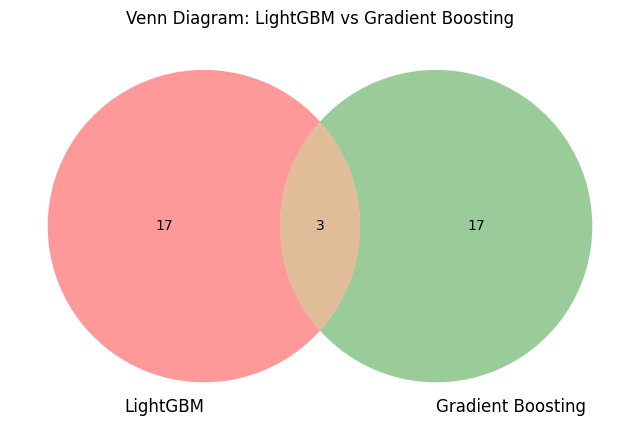

In [34]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

# Clean and standardize feature names to strings
rf_top_features_clean = [str(feature) for feature in ['1206', '1072', '1987', '1145', '2548', '1942', '1611', '1039', '1517', '1042', '2004', '366', '1679', '1402', '664', '2032', '1177', '2051', '753', '1182']]
xgb_top_features_clean = [str(feature) for feature in ['1723', '2004', '2096', '634', '20', '584', '88', '2615', '1611', '2643', '753', '475', '684', '2005', '900', '1199', 'QC', '18', 'Sample', '49']]
lasso_top_features_clean = [str(feature) for feature in ['2615', '2374', '1018', '1958', '584', '1377', '1836', '1940', '2047', '1890', '630', '716', '900', '805', '749', '1396', '514', '437', '475', '24']]
lgb_top_features_clean = [str(feature) for feature in ['584', '722', '633', '88', '553', '867', '753', '410', '435', '1648', '773', '1395', '2004', '930', '866', '2643', '998', '2005', '1599', '1778']]
gb_top_features_clean = [str(feature) for feature in ['1723', '584', '2096', '2617', '433', '1554', '20', '735', '2631', '168', '2005', '2242', '490', '2600', '1866', '771', '1680', '1154', '88', '1155']]

# Convert top features to sets for each model
rf_top_features_set = set(rf_top_features_clean)
xgb_top_features_set = set(xgb_top_features_clean)
lasso_top_features_set = set(lasso_top_features_clean)
lgb_top_features_set = set(lgb_top_features_clean)
gb_top_features_set = set(gb_top_features_clean)

# Pairwise Venn diagrams
model_pairs = [
    ('Random Forest', 'XGBoost', rf_top_features_set, xgb_top_features_set),
    ('Random Forest', 'Lasso', rf_top_features_set, lasso_top_features_set),
    ('Random Forest', 'LightGBM', rf_top_features_set, lgb_top_features_set),
    ('Random Forest', 'Gradient Boosting', rf_top_features_set, gb_top_features_set),
    ('XGBoost', 'Lasso', xgb_top_features_set, lasso_top_features_set),
    ('XGBoost', 'LightGBM', xgb_top_features_set, lgb_top_features_set),
    ('XGBoost', 'Gradient Boosting', xgb_top_features_set, gb_top_features_set),
    ('Lasso', 'LightGBM', lasso_top_features_set, lgb_top_features_set),
    ('Lasso', 'Gradient Boosting', lasso_top_features_set, gb_top_features_set),
    ('LightGBM', 'Gradient Boosting', lgb_top_features_set, gb_top_features_set)
]

# Generate Venn diagrams for each pair of models
for model1, model2, set1, set2 in model_pairs:
    plt.figure(figsize=(8, 6))
    
    # Generate the Venn diagram
    venn = venn2([set1, set2], set_labels=(model1, model2))
    
    # Find overlap (intersection) between the two sets
    overlap = set1.intersection(set2)
    
    if overlap:
        print(f"Overlap between {model1} and {model2}: {', '.join(sorted(overlap))}")
    else:
        print(f"No overlap between {model1} and {model2}")
    
    # Display the Venn diagram
    plt.title(f"Venn Diagram: {model1} vs {model2}")
    plt.show()


Overlap between Random Forest and XGBoost: 1611, 2004, 753
Overlap between XGBoost and Lasso: 2615, 475, 584, 900


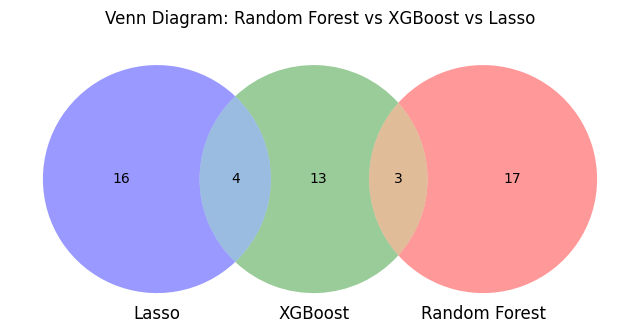

Overlap between Random Forest and XGBoost: 1611, 2004, 753
Overlap between Random Forest and LightGBM: 2004, 753
Overlap between XGBoost and LightGBM: 2004, 2005, 2643, 584, 753, 88
Overlap among Random Forest, XGBoost, and LightGBM: 2004, 753


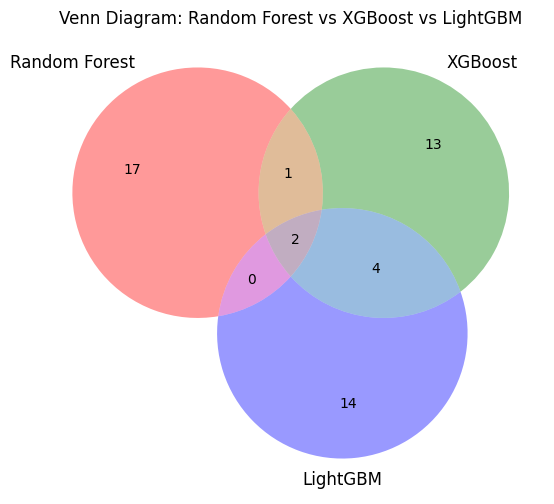

Overlap between Random Forest and XGBoost: 1611, 2004, 753
Overlap between XGBoost and Gradient Boosting: 1723, 20, 2005, 2096, 584, 88


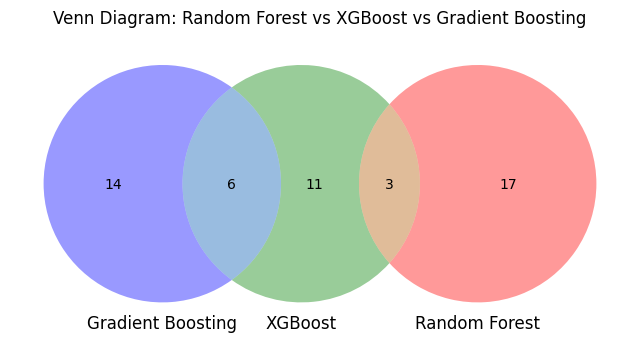

Overlap between Random Forest and LightGBM: 2004, 753
Overlap between Lasso and LightGBM: 584


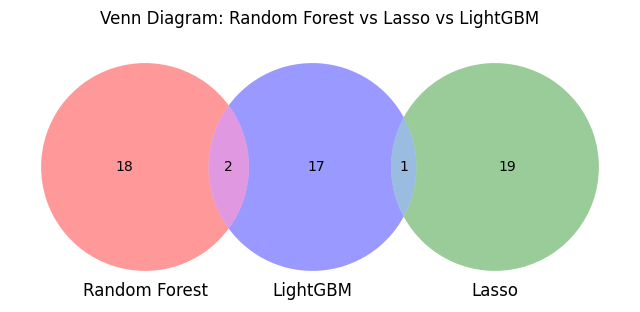

Overlap between Lasso and Gradient Boosting: 584


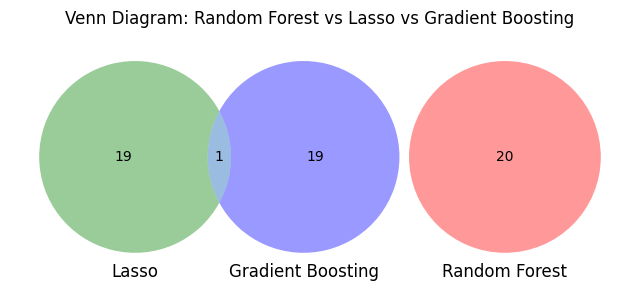

Overlap between Random Forest and LightGBM: 2004, 753
Overlap between LightGBM and Gradient Boosting: 2005, 584, 88


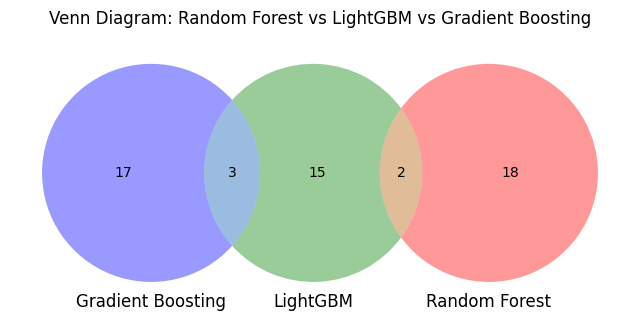

Overlap between XGBoost and Lasso: 2615, 475, 584, 900
Overlap between XGBoost and LightGBM: 2004, 2005, 2643, 584, 753, 88
Overlap between Lasso and LightGBM: 584
Overlap among XGBoost, Lasso, and LightGBM: 584


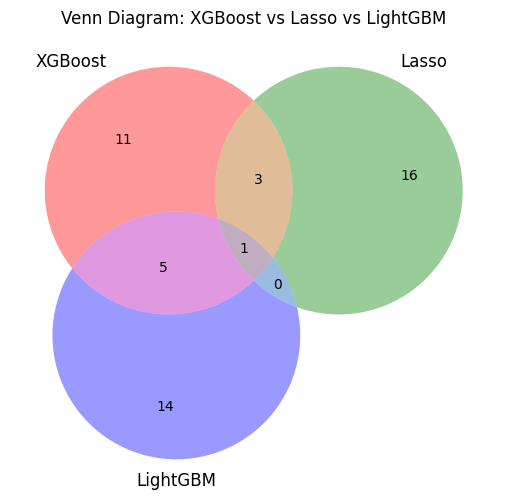

Overlap between XGBoost and Lasso: 2615, 475, 584, 900
Overlap between XGBoost and Gradient Boosting: 1723, 20, 2005, 2096, 584, 88
Overlap between Lasso and Gradient Boosting: 584
Overlap among XGBoost, Lasso, and Gradient Boosting: 584


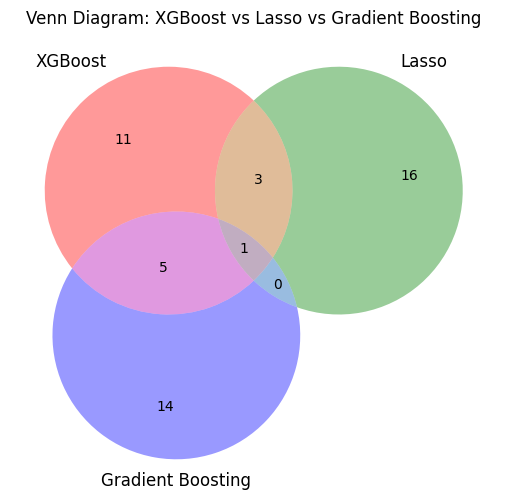

Overlap between XGBoost and LightGBM: 2004, 2005, 2643, 584, 753, 88
Overlap between XGBoost and Gradient Boosting: 1723, 20, 2005, 2096, 584, 88
Overlap between LightGBM and Gradient Boosting: 2005, 584, 88
Overlap among XGBoost, LightGBM, and Gradient Boosting: 2005, 584, 88


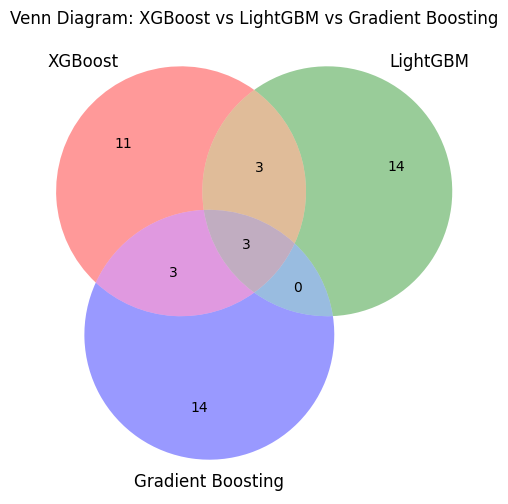

Overlap between Lasso and LightGBM: 584
Overlap between Lasso and Gradient Boosting: 584
Overlap between LightGBM and Gradient Boosting: 2005, 584, 88
Overlap among Lasso, LightGBM, and Gradient Boosting: 584


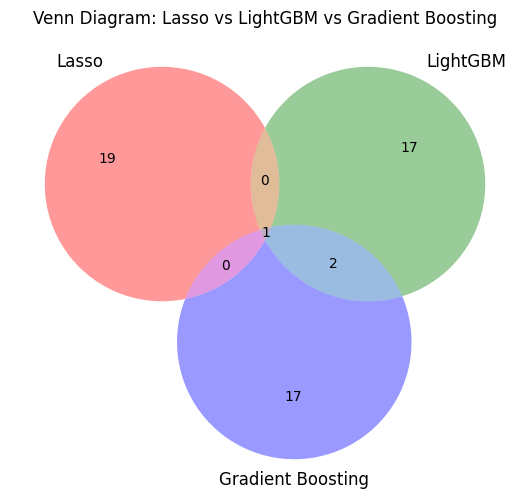

In [37]:
from matplotlib_venn import venn3

# Triple Venn diagrams
model_triplets = [
    ('Random Forest', 'XGBoost', 'Lasso', rf_top_features_set, xgb_top_features_set, lasso_top_features_set),
    ('Random Forest', 'XGBoost', 'LightGBM', rf_top_features_set, xgb_top_features_set, lgb_top_features_set),
    ('Random Forest', 'XGBoost', 'Gradient Boosting', rf_top_features_set, xgb_top_features_set, gb_top_features_set),
    ('Random Forest', 'Lasso', 'LightGBM', rf_top_features_set, lasso_top_features_set, lgb_top_features_set),
    ('Random Forest', 'Lasso', 'Gradient Boosting', rf_top_features_set, lasso_top_features_set, gb_top_features_set),
    ('Random Forest', 'LightGBM', 'Gradient Boosting', rf_top_features_set, lgb_top_features_set, gb_top_features_set),
    ('XGBoost', 'Lasso', 'LightGBM', xgb_top_features_set, lasso_top_features_set, lgb_top_features_set),
    ('XGBoost', 'Lasso', 'Gradient Boosting', xgb_top_features_set, lasso_top_features_set, gb_top_features_set),
    ('XGBoost', 'LightGBM', 'Gradient Boosting', xgb_top_features_set, lgb_top_features_set, gb_top_features_set),
    ('Lasso', 'LightGBM', 'Gradient Boosting', lasso_top_features_set, lgb_top_features_set, gb_top_features_set)
]

# Generate Venn diagrams for each triplet of models
for model1, model2, model3, set1, set2, set3 in model_triplets:
    plt.figure(figsize=(8, 6))
    
    # Generate the Venn diagram
    venn = venn3([set1, set2, set3], set_labels=(model1, model2, model3))
    plt.title(f"Venn Diagram: {model1} vs {model2} vs {model3}")
    
    # Extract subsets from the venn diagram
    subsets = venn.subset_labels
    
    # Print the overlapping features (if any) between the models
    overlap_1_2 = set1.intersection(set2)
    overlap_1_3 = set1.intersection(set3)
    overlap_2_3 = set2.intersection(set3)
    overlap_all = set1.intersection(set2).intersection(set3)
    
    if overlap_1_2:
        print(f"Overlap between {model1} and {model2}: {', '.join(sorted(overlap_1_2))}")
    if overlap_1_3:
        print(f"Overlap between {model1} and {model3}: {', '.join(sorted(overlap_1_3))}")
    if overlap_2_3:
        print(f"Overlap between {model2} and {model3}: {', '.join(sorted(overlap_2_3))}")
    if overlap_all:
        print(f"Overlap among {model1}, {model2}, and {model3}: {', '.join(sorted(overlap_all))}")
    
    plt.show()


### PC loadings

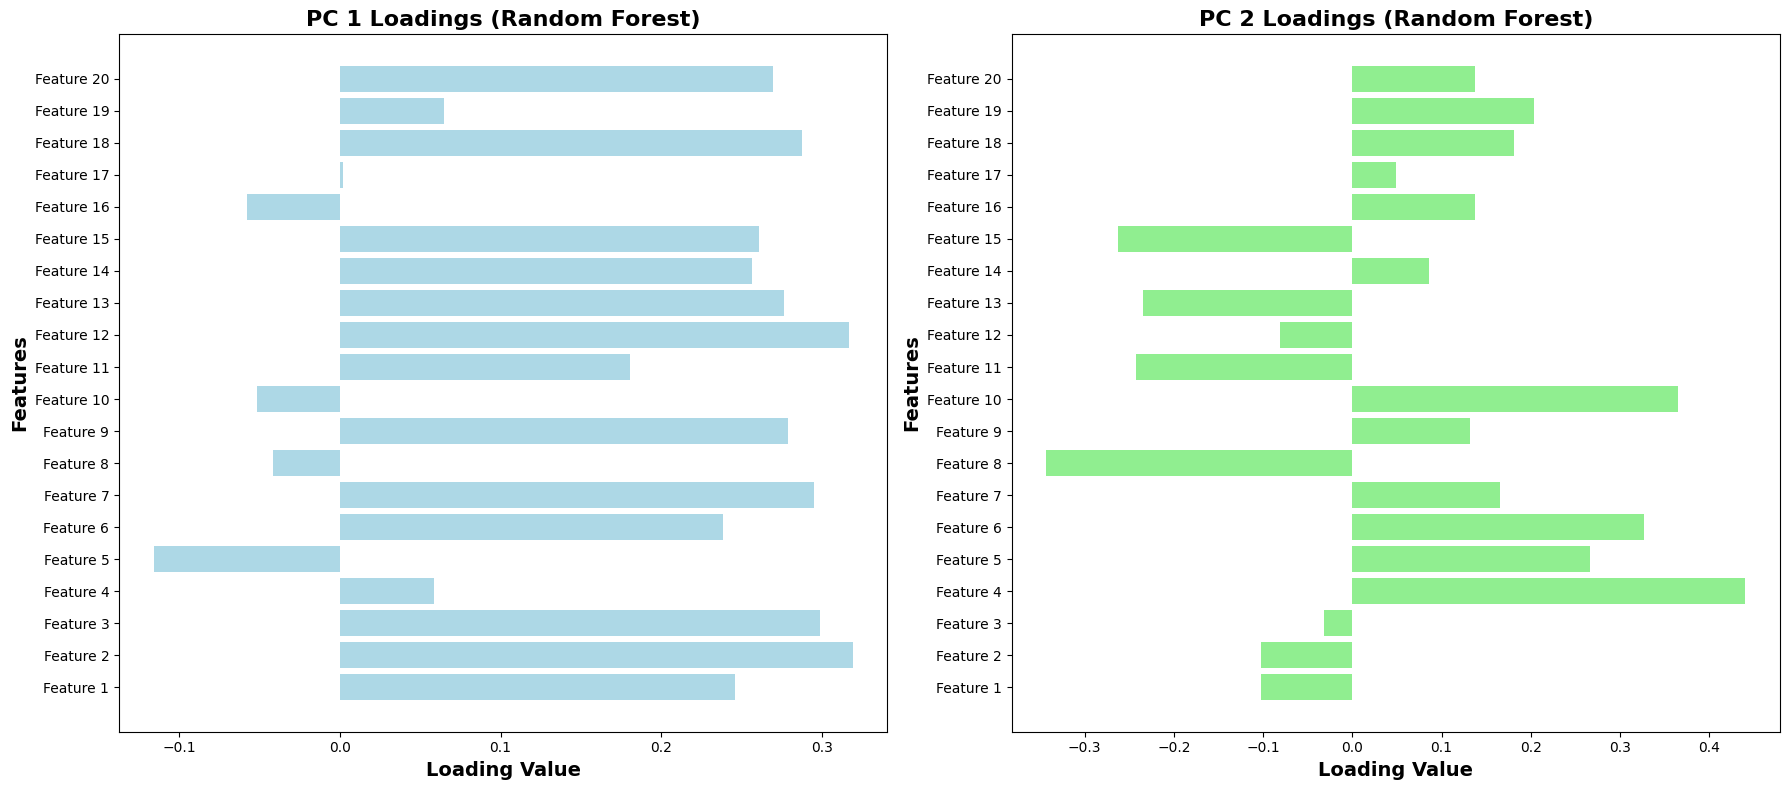

In [42]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

def plot_pca_loadings_rf(X_scaled, top_features_indices, model_name='Random Forest'):
    # Selecting only the top features for PCA
    X_top_features = X_scaled[:, top_features_indices]
    
    # Initialize and fit the PCA model
    pca = PCA(n_components=2, random_state=42)
    pca.fit(X_top_features)
    
    # Get the loadings (coefficients) of the features on the principal components
    loadings = pca.components_.T  # Transpose so that each column is a component, each row is a feature
    
    # Plot loadings for each principal component
    feature_names = [f'Feature {i+1}' for i in range(X_top_features.shape[1])]
    
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    
    # Plot loadings for Principal Component 1
    axes[0].barh(feature_names, loadings[:, 0], color='lightblue')
    axes[0].set_title(f'PC 1 Loadings ({model_name})', fontsize=16, fontweight='bold')
    axes[0].set_xlabel('Loading Value', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('Features', fontsize=14, fontweight='bold')
    
    # Plot loadings for Principal Component 2
    axes[1].barh(feature_names, loadings[:, 1], color='lightgreen')
    axes[1].set_title(f'PC 2 Loadings ({model_name})', fontsize=16, fontweight='bold')
    axes[1].set_xlabel('Loading Value', fontsize=14, fontweight='bold')
    axes[1].set_ylabel('Features', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

# For Random Forest model, we use the top features set
rf_top_features_clean = [str(feature) for feature in ['1206', '1072', '1987', '1145', '2548', '1942', '1611', '1039', '1517', '1042', '2004', '366', '1679', '1402', '664', '2032', '1177', '2051', '753', '1182']]
rf_top_features_set = set(rf_top_features_clean)

# Convert the top features to indices (assuming X is your original DataFrame)
# Ensure that X.columns corresponds to your feature names
top_features_indices = [list(X.columns).index(feature) for feature in rf_top_features_set]

# Call the function to plot the PCA loadings for Random Forest
plot_pca_loadings_rf(X_scaled, top_features_indices)


Explanation:
PCA Loadings:

The function plot_pca_loadings_rf() fits the PCA model on the scaled data for the Random Forest top features.
The PCA loadings are then extracted for the first two principal components (PC1 and PC2).
Visualization:

The bar plots show how much each feature contributes to the first two principal components.
A larger bar indicates a greater contribution of that feature to the corresponding principal component.
Random Forest Features:

The list rf_top_features_clean contains the top features identified for Random Forest, and those are used to extract indices from your scaled data.
Notes:
Ensure that X_scaled corresponds to your scaled data (features should be standardized before fitting PCA).
This will give you a visual understanding of which features have the highest influence on the first and second principal components in your Random Forest model.
Let me know if you have any issues!